In [7]:
import os
import numpy as np
import json
import pandas as pd
import ast
import scipy

import math

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

cwd = os.getcwd()

In [8]:
print(tf. __version__)
print(np. __version__)

2.9.1
1.21.5


In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Useful functions

In [10]:
def bbox_to_rect(bbox):
    """Convert bounding box to matplotlib format"""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(xy=(-1, bbox[0]), width=202,
                             height=bbox[1] - bbox[0], fill=False,
                             edgecolor='red', linewidth=1)

def bbox_borders_to_center(bbox):
    """Convert from (lower border, upper-border) to (center, height)"""
    x1, x2 = bbox[0], bbox[1]
    cx = (x1 + x2) / 2
    h = x2 - x1
    bbox = [cx, h]
    return bbox

def box_center_to_borders(bbox):
    """Convert from (center, height) to (lower border, upper-border)"""
    cx, h = bbox[0], bbox[1]
    x1 = cx - 0.5 * h
    x2 = cx + 0.5 * h
    bbox = [x1, x2]
    return bbox

In [11]:
def best_segment_to_bbox(outs):
    total = []
    for prediction in outs:
        image = []
        for row in prediction:
            segment = []
            for value in row:
                segment.append(round(value.numpy(),2))
            image.append(segment)
        total.append(image)

    best_segment = []
    for image in total:
        maxim = 0
        for i in range(0,7):
            if image[i][0] > maxim:
                maxim = image[i][0]
        best_segment.append(maxim)
    print(best_segment)

    array=[]
    for j in range(0, len(total)):
        for i in range(0,7):
            if total[j][i][0] == best_segment[j]:
                center = (total[j][i][1] + i)*21
                height = total[j][i][2]*21
                array.append([round(center,2),round(abs(height),2)])

    borders = []

    for box in array:
        box = box_center_to_borders(box)
        borders.append(box)

    return borders

def threshold_segment_to_bbox(outs,threshold):
    total = []
    for prediction in outs:
        image = []
        for row in prediction:
            segment = []
            for value in row:
                segment.append(round(value.numpy(),2))
            image.append(segment)
        total.append(image)

    best_segment = []
    for image in total:
        maxim = []
        for i in range(0,7):
            if image[i][0] > threshold:
                maxim.append(image[i][0])
        best_segment.append(maxim)
    print(best_segment)

    centerheights=[]
    for j in range(0, len(total)):
        array=[]
        for i in range(0,7):
            aux=[]
            for k in range(0,len(best_segment[j])):
                if total[j][i][0] == best_segment[j][k]:
                    center = (total[j][i][1] + i)*21
                    height = total[j][i][2]*21
                    aux.append(round(center,2))
                    aux.append(round(abs(height),2))
            if aux != []:
                array.append(aux)

        centerheights.append(array)
        
    borders = []
    for boxes in centerheights:
        aux = []
        for box in boxes:
            box = box_center_to_borders(box)
            aux.append(box)
        borders.append(aux)

    return borders

In [12]:
def calculate_iou(bbox1, bbox2):
    if ((np.min(bbox1)>np.max(bbox2)) | (np.min(bbox2)>np.max(bbox1))):
        iou = 0.0
    else:
        union = [np.min([bbox1[0],bbox2[0]]),np.max([bbox1[1],bbox2[1]])]
        union_len = union[1] - union[0]
        
        inter = [np.max([bbox1[0],bbox2[0]]),np.min([bbox1[1],bbox2[1]])]
        inter_len = inter[1] - inter[0]

        iou =  inter_len / union_len
    return iou

def check_iou_single(Y_true,pred_boxes):
    count = 0.0
    #Y_true = test_df["bbox"].values.tolist()
    for i in range(len(Y_true)):
        print(f'IOU of image {i}: {calculate_iou(Y_true[i],pred_boxes[i])}')
        count += calculate_iou(Y_true[i],pred_boxes[i])
    print(f'Total IOU of {count}, max IOU value is {len(Y_true)}, {count*100/float(len(Y_true))}%')

def check_iou_threshold(Y_true,pred_boxes):
    count = 0.0
    #Y_true = test_df["bbox"].values.tolist()
    for i in range(len(Y_true)):
        bestbbox = 0.0
        for bbox in pred_boxes[i]:
            if calculate_iou(Y_true[i],bbox) > bestbbox:
                bestbbox = calculate_iou(Y_true[i],bbox)
        print(f'IOU of image {i}: {bestbbox}')
        count += bestbbox
    print(f'Total IOU of {count}, max IOU value is {len(Y_true)}, {count*100/float(len(Y_true))}%')
    return count*100/float(len(Y_true))

def check_iou_overlap(pred_boxes):
    for i in range(len(pred_boxes)):
        if (len(pred_boxes) > 1):
            for bbox1 in pred_boxes[i]:
                for bbox2 in pred_boxes[i]:
                    if (bbox1 != bbox2):
                        print(f'Overlapping of {bbox1} with {bbox2} is {calculate_iou(bbox1, bbox2)}')
                        

## Dataframe loading

In [13]:
#LOAD 516 DATASET FOR FIRST TRAINING AND VALIDATION
dataframe_name = "df_luis_5_bbox_segmented"
pkl_path = f"./pickle/{dataframe_name}.pkl"
df = pd.read_pickle(pkl_path)

In [14]:
df.reset_index(inplace=True)
df.drop('index', axis= 1, inplace=True)
df

Id presence  \
0   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
1   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
2   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
3   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
4   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
..                                                ...      ...   
76  C:\Users\luisg\radar_acquisitions\recordings\b...        1   
77  C:\Users\luisg\radar_acquisitions\recordings\b...        1   
78  C:\Users\luisg\radar_acquisitions\recordings\b...        1   
79  C:\Users\luisg\radar_acquisitions\recordings\b...        1   
80  C:\Users\luisg\radar_acquisitions\recordings\b...        1   

                                                 data  \
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 8.034872939559035e-...   
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.5555243542351457e...   
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 8.45331887376697e-1...   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 3.8003771514947853e...   
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0471688198795585e...   
..                                                ...   
76  [[0.0, 0.0, 0.0, 0.0, 0.0, 4.762209259274762e-...   
77  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.1939769319724238e...   
78  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.3622539971619137e...   
79  [[0.0, 0.0, 0.0, 0.0, 0.0, 7.3050508590492e-10...   
80  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.5981306231868424e...   

                                              fftdata        bbox  \
0   [[-160.2950249133561, -194.72275445022544, -18...    [14, 42]   
1   [[-161.43283565674847, -190.55028151463148, -1...    [46, 72]   
2   [[-173.09489706100504, -200.58769603161903, -2...    [15, 47]   
3   [[-163.1541434009199, -182.87782129028682, -18...    [71, 97]   
4   [[-160.0532420278023, -181.14059388583507, -18...    [42, 74]   
..                                                ...         ...   
76  [[-162.53141628497448, -190.06063901683828, -1...  [128, 148]   
77  [[-161.31621754575863, -186.35465427231804, -1...  [126, 148]   
78  [[-162.35059763677089, -185.6312602737847, -18...   [77, 105]   
79  [[-159.20551436727033, -196.07560131234337, -1...    [22, 45]   
80  [[-157.94193154284397, -172.94657204814033, -1...     [5, 22]   

    bbox_center                                     bbox_segmented  
0    [28.0, 28]  [[0, 0, 0], [1, 0.3333333333333333, 1.33333333...  
1    [59.0, 26]  [[0, 0, 0], [0, 0, 0], [1, 0.8095238095238095,...  
2    [31.0, 32]  [[0, 0, 0], [1, 0.47619047619047616, 1.5238095...  
3    [84.0, 26]  [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...  
4    [58.0, 32]  [[0, 0, 0], [0, 0, 0], [1, 0.7619047619047619,...  
..          ...                                                ...  
76  [138.0, 20]  [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...  
77  [137.0, 22]  [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...  
78   [91.0, 28]  [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...  
79   [33.5, 23]  [[0, 0, 0], [1, 0.5952380952380952, 1.09523809...  
80   [13.5, 17]  [[1, 0.6428571428571429, 0.8095238095238095], ...  

[81 rows x 7 columns]

# Balancing check

In [15]:
balancing = []
for index, row in df.iterrows():
    for i in range(len(row['bbox_segmented'])):
        if row['bbox_segmented'][i][0] != 0:
            balancing.append(i)
print(f'Correct lenght is {len(df)} and got {len(balancing)}')            
print(balancing)
d = {}
for x in range(max(balancing)+1):
    d["balancing_{0}".format(x)] = balancing.count(x)
print(d)

Correct lenght is 81 and got 81
[1, 2, 1, 4, 2, 2, 1, 1, 0, 3, 1, 1, 1, 3, 2, 2, 3, 1, 1, 5, 2, 4, 3, 0, 4, 2, 2, 3, 5, 2, 3, 3, 2, 2, 3, 3, 1, 2, 0, 0, 0, 4, 4, 3, 4, 4, 4, 1, 3, 3, 1, 3, 2, 4, 3, 2, 1, 1, 1, 3, 1, 0, 0, 0, 2, 0, 4, 1, 2, 2, 1, 1, 1, 3, 5, 4, 6, 6, 4, 1, 0]
{'balancing_0': 10, 'balancing_1': 21, 'balancing_2': 17, 'balancing_3': 16, 'balancing_4': 12, 'balancing_5': 3, 'balancing_6': 2}


In [16]:
df['segment'] = balancing
df

Id presence  \
0   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
1   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
2   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
3   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
4   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
..                                                ...      ...   
76  C:\Users\luisg\radar_acquisitions\recordings\b...        1   
77  C:\Users\luisg\radar_acquisitions\recordings\b...        1   
78  C:\Users\luisg\radar_acquisitions\recordings\b...        1   
79  C:\Users\luisg\radar_acquisitions\recordings\b...        1   
80  C:\Users\luisg\radar_acquisitions\recordings\b...        1   

                                                 data  \
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 8.034872939559035e-...   
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.5555243542351457e...   
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 8.45331887376697e-1...   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 3.8003771514947853e...   
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0471688198795585e...   
..                                                ...   
76  [[0.0, 0.0, 0.0, 0.0, 0.0, 4.762209259274762e-...   
77  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.1939769319724238e...   
78  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.3622539971619137e...   
79  [[0.0, 0.0, 0.0, 0.0, 0.0, 7.3050508590492e-10...   
80  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.5981306231868424e...   

                                              fftdata        bbox  \
0   [[-160.2950249133561, -194.72275445022544, -18...    [14, 42]   
1   [[-161.43283565674847, -190.55028151463148, -1...    [46, 72]   
2   [[-173.09489706100504, -200.58769603161903, -2...    [15, 47]   
3   [[-163.1541434009199, -182.87782129028682, -18...    [71, 97]   
4   [[-160.0532420278023, -181.14059388583507, -18...    [42, 74]   
..                                                ...         ...   
76  [[-162.53141628497448, -190.06063901683828, -1...  [128, 148]   
77  [[-161.31621754575863, -186.35465427231804, -1...  [126, 148]   
78  [[-162.35059763677089, -185.6312602737847, -18...   [77, 105]   
79  [[-159.20551436727033, -196.07560131234337, -1...    [22, 45]   
80  [[-157.94193154284397, -172.94657204814033, -1...     [5, 22]   

    bbox_center                                     bbox_segmented  segment  
0    [28.0, 28]  [[0, 0, 0], [1, 0.3333333333333333, 1.33333333...        1  
1    [59.0, 26]  [[0, 0, 0], [0, 0, 0], [1, 0.8095238095238095,...        2  
2    [31.0, 32]  [[0, 0, 0], [1, 0.47619047619047616, 1.5238095...        1  
3    [84.0, 26]  [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...        4  
4    [58.0, 32]  [[0, 0, 0], [0, 0, 0], [1, 0.7619047619047619,...        2  
..          ...                                                ...      ...  
76  [138.0, 20]  [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...        6  
77  [137.0, 22]  [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...        6  
78   [91.0, 28]  [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...        4  
79   [33.5, 23]  [[0, 0, 0], [1, 0.5952380952380952, 1.09523809...        1  
80   [13.5, 17]  [[1, 0.6428571428571429, 0.8095238095238095], ...        0  

[81 rows x 8 columns]

# Define custom loss function

In [17]:
def YOLO_loss(true_list, pred_list):
    
    lambda_coord = 10.0
    lambda_obj = 3.0
    lambda_noobj = 0.5

    true_list=tf.reshape(true_list,[-1,7,3])
    pred_list=tf.reshape(pred_list,[-1,7,3])

    error = 0.0

    exists_box = true_list[...,0]

    mse = tf.keras.losses.MeanSquaredError()

    """Presence probability"""
    pprobability = lambda_obj*exists_box*mse(pred_list[...,0], true_list[...,0])
    + lambda_noobj*(1-exists_box)*mse(pred_list[...,0], true_list[...,0])

    """Center position"""
    center = lambda_coord*exists_box*mse(pred_list[...,1], true_list[...,1]) 

    """Height"""
    height = lambda_coord*exists_box*mse(tf.math.sqrt(tf.math.abs(pred_list[...,2])), tf.math.sqrt(tf.math.abs(true_list[...,2])))

    """Error calculation"""
    error = pprobability + center + height

    return error

## Training the best architecture with different splits

In [18]:
def train_random_states(amount):
    ious = []
    for i in range(amount):
        print('----------------------------------------------------------------------------')
        print(f'RND STATE NUMBER = {i}')
        print('----------------------------------------------------------------------------')
        #SPLIT THE DATASET IN TRAIN AND TEST
        from sklearn.model_selection import train_test_split

        train_df, test_df = train_test_split(df, test_size=0.15, random_state = i)
        
        working_df = train_df
        train_list = working_df.data

        """
        Convert train list to an array type object
        """
        images = []
        for image in train_list:
            images.append(image)
        train_list = images

        """
        zscore normalization part of the preprocessing. correcting the dimension of the network.
        """

        
        train_list = scipy.stats.zscore(train_list, axis=None)


        train_tensor = tf.convert_to_tensor(train_list)
        train_tensor = tf.expand_dims(train_tensor, -1)

        

        """
        assigning label 
        """

        train_label = working_df["bbox_segmented"]
        segments = []
        for segment in train_label:
            segment_linear = []
            for array in segment:
                for value in array:
                    segment_linear.append(value)
            segments.append(segment_linear)

        train_label = segments

        train_label = tf.convert_to_tensor(train_label)

        

        """Dimensions of the inputs"""
        img_h, img_w = 149, 201
        num_outputs = 21
        
        """
        Perform the same preprocessing steps of the training set to the test set too.
        """
        test_label = test_df["bbox_segmented"]
        segments = []
        for segment in test_label:
            segment_linear = []
            for array in segment:
                for value in array:
                    segment_linear.append(value)
            segments.append(segment_linear)

        test_label = segments

        test_label = tf.convert_to_tensor(test_label)

        test_list = test_df["data"]

        images = []
        for image in test_list:
            images.append(image)
        test_list = images

        """
        zscore normalization part of the preprocessing. correcting the dimension of the network.
        """

        
        test_list = scipy.stats.zscore(test_list, axis=None)


        #max = np.max(train_list)
        #min = np.min(train_list)
        #train_list = np.array([[[(x - min) / (max - min) for x in y] for y in z] for z in train_list])
        test_tensor = tf.convert_to_tensor(test_list)
        test_tensor = tf.expand_dims(test_tensor, -1)

        

        test_images = test_tensor

        """
        test the best performing network on the test set.
        """

        
        # Merge inputs and targets

        inputs = np.array(train_tensor)
        targets = train_label

        """retrain the best performing network on train + validation dataset""" 

        # Loss
        #loss = 'mean_squared_error'

        # learning rate
        lr = 0.3e-4

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        # -------------------

        # Validation metrics
        # ------------------

        metrics = ['mae']

        batch_size = 32

        callbacks = []

        n_epoch = 600

        conv_kernels = [7]

        MP_dims = [2]

        #number of convolution blocks
        conv_blocks = [5]

        #Dropout rate
        drop_out_rates = [0.3]

        #numbers of starting filters
        start_fs = [20]

        #dilation_rate
        dilation_rates = [1]

        regularizer = None

        for MP_dim in MP_dims:
            for conv_kernel in conv_kernels:
                for conv_block in conv_blocks:
                    for drop_out_rate in drop_out_rates:
                        for n_filter in start_fs:
                            for dilation_rate in dilation_rates:


                                experiment = f"YOLO_test_28_{i}"


                                model = tf.keras.Sequential()

                                input_shape = [img_h, img_w, 1]

                                model = tf.keras.Sequential()

                                model.add(tf.keras.layers.MaxPool2D(pool_size=(MP_dim, MP_dim), input_shape=input_shape))

                                for j in range(conv_block):
                                    # Conv block: Conv2D -> Activation -> Pooling
                                    model.add(tf.keras.layers.Conv2D(filters=n_filter, 
                                                                     kernel_size=(conv_kernel, conv_kernel),
                                                                     strides=(1, 1),
                                                                     dilation_rate = dilation_rate,
                                                                     padding='same',
                                                                     input_shape=input_shape))   
                                    model.add(tf.keras.layers.Conv2D(filters=n_filter, 
                                                                     kernel_size=(conv_kernel, conv_kernel),
                                                                     strides=(1, 1),
                                                                     dilation_rate = dilation_rate,
                                                                     padding='same',
                                                                     input_shape=input_shape,
                                                                     activation='relu'))
                                    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

                                # Classifier

                                model.add(tf.keras.layers.Flatten())
                                model.add(tf.keras.layers.Dropout(drop_out_rate))
                                model.add(tf.keras.layers.Dense(units=21, activation='linear'))

                                # Compile the model
                                model.compile(loss=YOLO_loss,
                                            optimizer=optimizer,
                                            metrics=metrics)


                                # Generate a print
                                print('------------------------------------------------------------------------')

                                # Fit data to model
                                history = model.fit(inputs, targets,
                                            batch_size=batch_size,
                                            epochs=n_epoch,
                                            callbacks = callbacks,
                                            verbose=False)

                                MODELS_DIR = f'models_full_train/experiment_{experiment}/experiment_{experiment}_{i}/{MP_dim}-{conv_kernel}-{conv_block}-{n_filter}-{drop_out_rate}-{dilation_rate}/'
                                if not os.path.exists(MODELS_DIR):
                                    os.makedirs(MODELS_DIR)
                                MODEL_TF = MODELS_DIR + f'model'
                                MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
                                MODEL_TFLITE = MODELS_DIR + 'model.tflite'
                                model.save(MODEL_TF)

                                def representative_dataset():
                                    for data in tf.data.Dataset.from_tensor_slices((inputs)).batch(1).take(100):
                                        #print(data)
                                        yield [tf.dtypes.cast(data, tf.float32)]


                                converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
                                converter.optimizations = [tf.lite.Optimize.DEFAULT]
                                # Enforce integer only quantization
                                converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
                                converter.inference_input_type = tf.int8
                                converter.inference_output_type = tf.int8
                                # Provide a representative dataset to ensure we quantize correctly.
                                converter.representative_dataset = representative_dataset
                                model_tflite = converter.convert()

                                open(MODEL_TFLITE, "wb").write(model_tflite)
                                #open(MODEL_TFLITE2, "wb").write(model_tflite)
                                
                                
        outs = model(test_images)#, test_labels, verbose=2)
        outs= tf.reshape(outs,[-1,7,3])
        print(outs.shape)
        total = []
        for prediction in outs:
            image = []
            for row in prediction:
                segment = []
                for value in row:
                    segment.append(round(value.numpy(),2))
                image.append(segment)
            total.append(image)
        print('Model predictions:')
        print(tf.convert_to_tensor(total))
        print('Actual values:')
        print(tf.reshape(test_label,[-1,7,3]))

        Y_true = test_df["bbox"].values.tolist()
        
        confidence_thresholds = [0.0]
        total_ious = []
        for value in confidence_thresholds:
            pred_boxes = threshold_segment_to_bbox(outs, value)
            iou = check_iou_threshold(Y_true,pred_boxes)
            total_ious.append(iou)
        print(f'RANDOM STATE NUMBER {i} average IOU is {sum(total_ious) / len(total_ious)}%')
        ious.append(sum(total_ious) / len(total_ious))
    row = {'ious' : ious}
    JSON_DIR = f'json_child/experiment_YOLO_test_28/n_epoch_600'
    if not os.path.exists(JSON_DIR):
        os.makedirs(JSON_DIR)
    try:
        with open(f'{JSON_DIR}/ious.json', 'w') as f:
            json.dump(row, f)
    except Exception as e:
        print(e)

In [19]:
train_random_states(40)

----------------------------------------------------------------------------
RND STATE NUMBER = 0
----------------------------------------------------------------------------
------------------------------------------------------------------------


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_0/experiment_YOLO_test_28_0_0/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_0/experiment_YOLO_test_28_0_0/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.12  0.01  0.02]
  [-0.    0.11  0.01]
  [ 0.14 -0.01 -0.05]
  [ 0.86  0.51  0.83]
  [ 0.09  0.04 -0.01]
  [-0.07  0.01 -0.03]
  [-0.09 -0.06  0.05]]

 [[ 0.08 -0.1   0.01]
  [ 0.01  0.06 -0.06]
  [ 0.1   0.08 -0.04]
  [ 1.19  0.67  1.15]
  [ 0.27  0.11  0.12]
  [ 0.03 -0.06  0.01]
  [-0.28 -0.02  0.01]]

 [[ 0.89  0.94  0.72]
  [ 0.09  0.07  0.15]
  [-0.    0.23  0.01]
  [-0.07 -0.02  0.  ]
  [-0.17 -0.03 -0.08]
  [-0.1   0.04  0.03]
  [ 0.03  0.14 -0.05]]

 [[-0.02 -0.05  0.  ]
  [ 0.02  0.13  0.02]
  [ 0.09 -0.02 -0.07]
  [ 0.64  0.51  0.6 ]
  [ 0.3   0.13  0.22]
  [ 0.06  0.05 -0.02]
  [-0.1   0.    0.06]]

 [[ 0.05  0.14  0.03]
  [ 0.47  0.44  0.27]
  [ 0.59  0.12 -0.63]
  [ 0.06  0.01  0.05]
  [ 0.05 -0.11 -0.03]
  [-0.08 -0.03 -0.03]
  [ 0.03  0.07  0.06]]

 [[ 0.32  0.   -0.08]
  [ 0.42  0.31  0.2 ]
  [ 0.02  0.17 -0.02]
  [ 0.16 -0.09  0.06]
  [ 0.87  0.76  0.83]
  [ 0.16  0.01  0.02]
  [ 0.   -0.06 -0.08]]

 [[ 0.05 -0.07  0.06]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_1/experiment_YOLO_test_28_1_1/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_1/experiment_YOLO_test_28_1_1/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.17  0.19  0.19]
  [ 0.04  0.02  0.01]
  [ 0.02  0.05  0.01]
  [ 0.15  0.03  0.08]
  [-0.    0.03  0.01]
  [ 0.03  0.03 -0.01]
  [ 0.04  0.02  0.02]]

 [[ 0.06 -0.01  0.01]
  [ 0.08 -0.   -0.05]
  [ 0.07  0.07  0.08]
  [ 0.41  0.34  0.38]
  [ 0.12 -0.04  0.03]
  [-0.    0.01  0.04]
  [ 0.01 -0.   -0.01]]

 [[ 0.04 -0.01  0.01]
  [ 0.06 -0.01  0.02]
  [ 0.01  0.01  0.  ]
  [ 0.28  0.26  0.25]
  [ 0.14  0.    0.07]
  [-0.    0.02  0.  ]
  [-0.   -0.01 -0.02]]

 [[-0.01  0.02 -0.01]
  [-0.07  0.01 -0.06]
  [ 0.55  0.5   0.57]
  [ 0.01  0.04 -0.04]
  [ 0.04  0.01 -0.02]
  [ 0.07  0.03  0.05]
  [-0.01 -0.01 -0.03]]

 [[ 0.04  0.02 -0.01]
  [ 0.06  0.01 -0.02]
  [ 0.03  0.03  0.  ]
  [ 0.1   0.11  0.06]
  [ 0.19  0.09  0.21]
  [ 0.02  0.06  0.01]
  [ 0.03 -0.01  0.01]]

 [[ 0.08 -0.01  0.02]
  [ 0.79  0.38  0.71]
  [-0.04 -0.05 -0.  ]
  [ 0.12  0.18 -0.02]
  [-0.02  0.01  0.04]
  [-0.08  0.03  0.03]
  [-0.04  0.02 -0.02]]

 [[-0.01 -0.03  0.  ]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_2/experiment_YOLO_test_28_2_2/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_2/experiment_YOLO_test_28_2_2/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.01 -0.02  0.02]
  [ 0.17  0.22 -0.2 ]
  [ 0.43  0.36  0.46]
  [-0.01 -0.05 -0.04]
  [ 0.02  0.02  0.02]
  [-0.08 -0.01  0.01]
  [ 0.06  0.05 -0.03]]

 [[ 0.1   0.03  0.07]
  [ 0.07 -0.02 -0.01]
  [ 0.12  0.04  0.05]
  [ 0.99  0.67  0.98]
  [ 0.17  0.05  0.05]
  [ 0.05 -0.01 -0.04]
  [-0.03  0.05  0.  ]]

 [[-0.05 -0.01  0.  ]
  [ 0.04  0.01 -0.05]
  [ 0.5   0.38  0.59]
  [ 0.04  0.02  0.06]
  [ 0.1   0.04  0.01]
  [-0.04 -0.06 -0.02]
  [ 0.04  0.01  0.02]]

 [[ 0.04 -0.07 -0.1 ]
  [ 0.04  0.05 -0.05]
  [-0.01  0.1   0.08]
  [ 0.85  0.64  0.62]
  [ 0.69  0.39  0.53]
  [ 0.21 -0.11  0.02]
  [-0.08 -0.04  0.02]]

 [[ 0.04  0.02 -0.09]
  [ 0.15 -0.02 -0.11]
  [-0.09  0.09 -0.13]
  [ 0.28 -0.06  0.06]
  [ 0.79  0.54  0.69]
  [ 0.17  0.1   0.  ]
  [-0.14  0.08  0.03]]

 [[-0.04 -0.01 -0.04]
  [ 0.73  0.7  -0.87]
  [-0.02  0.04 -0.01]
  [-0.04 -0.06  0.02]
  [ 0.02 -0.02  0.02]
  [-0.01 -0.02 -0.07]
  [ 0.03  0.01  0.04]]

 [[-0.08 -0.09  0.03]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_3/experiment_YOLO_test_28_3_3/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_3/experiment_YOLO_test_28_3_3/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.13  0.13 -0.11]
  [ 0.23  0.13 -0.19]
  [ 0.06  0.02  0.04]
  [-0.05  0.07  0.11]
  [ 0.01 -0.    0.03]
  [ 0.02  0.01 -0.04]
  [ 0.07 -0.    0.06]]

 [[ 0.01 -0.04  0.02]
  [ 0.75  0.69 -0.97]
  [ 0.09 -0.05  0.02]
  [-0.   -0.02 -0.07]
  [ 0.07 -0.02  0.  ]
  [ 0.04  0.05 -0.02]
  [ 0.01 -0.02 -0.05]]

 [[ 0.01 -0.05 -0.04]
  [ 0.37  0.42 -0.41]
  [ 0.1   0.05  0.04]
  [-0.01 -0.02  0.04]
  [ 0.07  0.03 -0.07]
  [ 0.06  0.07 -0.02]
  [ 0.04 -0.01  0.01]]

 [[-0.02 -0.08  0.02]
  [ 0.75  0.73 -0.96]
  [ 0.03 -0.03  0.02]
  [ 0.   -0.03 -0.04]
  [ 0.06  0.02 -0.06]
  [ 0.01  0.    0.  ]
  [-0.03 -0.06 -0.02]]

 [[-0.01  0.03 -0.03]
  [-0.    0.04  0.01]
  [ 0.82  0.65  1.06]
  [ 0.18  0.03 -0.03]
  [ 0.06  0.02  0.03]
  [ 0.1  -0.01  0.02]
  [ 0.02  0.06 -0.02]]

 [[ 0.17  0.03 -0.06]
  [ 0.45  0.55 -0.46]
  [ 0.07 -0.   -0.02]
  [ 0.02  0.08 -0.01]
  [ 0.01 -0.02 -0.02]
  [-0.02  0.   -0.02]
  [-0.02  0.03  0.01]]

 [[-0.03 -0.07  0.11]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_4/experiment_YOLO_test_28_4_4/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_4/experiment_YOLO_test_28_4_4/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.09  0.03  0.05]
  [ 0.04  0.03  0.05]
  [ 0.17  0.06 -0.06]
  [ 0.12  0.07  0.  ]
  [ 0.18 -0.01  0.11]
  [ 0.1  -0.08 -0.02]
  [ 0.13  0.16  0.28]]

 [[ 0.04  0.15  0.03]
  [ 0.14 -0.05 -0.06]
  [ 0.96  0.9  -0.95]
  [ 0.27 -0.03 -0.04]
  [ 0.09  0.08  0.04]
  [ 0.08  0.1   0.01]
  [-0.08  0.01  0.1 ]]

 [[-0.04 -0.21 -0.08]
  [ 0.06 -0.17 -0.01]
  [ 0.04 -0.02 -0.06]
  [ 0.58  0.36 -0.33]
  [ 1.05  0.69  1.23]
  [ 0.02 -0.   -0.01]
  [ 0.13 -0.15  0.02]]

 [[-0.01  0.03 -0.01]
  [-0.01 -0.01  0.  ]
  [ 0.82  0.47 -0.82]
  [ 0.05  0.1  -0.06]
  [ 0.05 -0.01 -0.01]
  [ 0.1  -0.    0.03]
  [-0.02 -0.03 -0.02]]

 [[ 0.2   0.15  0.1 ]
  [ 0.14  0.05 -0.05]
  [ 0.14  0.05 -0.01]
  [ 0.18  0.11  0.  ]
  [ 0.2   0.07  0.14]
  [ 0.03 -0.06  0.07]
  [ 0.07  0.11  0.06]]

 [[-0.05 -0.06  0.01]
  [ 0.94  0.89 -0.9 ]
  [ 0.15  0.02  0.04]
  [-0.07  0.01  0.04]
  [ 0.    0.06  0.02]
  [-0.04  0.06  0.02]
  [-0.03 -0.   -0.03]]

 [[ 0.1  -0.04 -0.01]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_5/experiment_YOLO_test_28_5_5/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_5/experiment_YOLO_test_28_5_5/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.06  0.15  0.04]
  [ 1.98  1.71 -1.8 ]
  [ 0.27 -0.03  0.15]
  [ 0.15  0.15 -0.13]
  [-0.15 -0.04  0.  ]
  [-0.07  0.06 -0.02]
  [ 0.15  0.04 -0.01]]

 [[-0.34 -0.17  0.01]
  [-0.27 -0.17 -0.02]
  [ 0.79  0.97 -1.08]
  [ 0.78  0.31 -0.57]
  [ 0.16  0.12  0.05]
  [ 0.07  0.04 -0.  ]
  [ 0.04  0.06 -0.04]]

 [[-0.04 -0.03 -0.06]
  [ 1.15  0.88 -1.27]
  [ 0.18  0.01 -0.03]
  [ 0.02  0.09 -0.02]
  [ 0.24  0.13 -0.05]
  [ 0.03  0.   -0.03]
  [ 0.06  0.03 -0.01]]

 [[ 0.01 -0.13 -0.08]
  [ 0.05  0.07  0.09]
  [ 0.01  0.   -0.07]
  [ 1.89  1.3  -1.98]
  [ 0.13 -0.08  0.06]
  [-0.07  0.02 -0.03]
  [ 0.34  0.09 -0.09]]

 [[ 0.1   0.22 -0.  ]
  [ 0.24  0.09  0.  ]
  [ 0.8   0.5  -0.94]
  [ 0.21  0.02 -0.13]
  [ 0.1  -0.17 -0.04]
  [ 0.02 -0.07  0.03]
  [ 0.04  0.02  0.02]]

 [[ 0.25  0.27  0.14]
  [-0.02  0.11  0.06]
  [-0.02 -0.    0.12]
  [ 0.95  0.81 -0.88]
  [ 0.38  0.08 -0.06]
  [-0.12 -0.16 -0.17]
  [-0.08  0.04  0.12]]

 [[-0.07  0.07  0.01]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_6/experiment_YOLO_test_28_6_6/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_6/experiment_YOLO_test_28_6_6/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.01  0.02  0.08]
  [-0.02 -0.01 -0.07]
  [ 1.15  0.67 -1.05]
  [ 0.11 -0.07 -0.02]
  [ 0.11  0.04  0.19]
  [-0.03 -0.11 -0.07]
  [-0.02 -0.    0.08]]

 [[ 0.22  0.25  0.26]
  [ 1.13  0.86  1.26]
  [ 0.16 -0.03 -0.09]
  [ 0.26  0.34  0.07]
  [ 0.08  0.12  0.27]
  [-0.01  0.25  0.03]
  [ 0.15  0.09  0.14]]

 [[ 0.06 -0.01  0.07]
  [ 0.   -0.04 -0.03]
  [ 0.   -0.01  0.03]
  [ 0.41  0.43  0.33]
  [ 0.34  0.02 -0.  ]
  [ 0.02  0.02  0.02]
  [-0.03 -0.01 -0.06]]

 [[ 0.11  0.05  0.05]
  [-0.21 -0.05 -0.11]
  [-0.01  0.16 -0.05]
  [ 0.4   0.37  0.68]
  [ 0.24  0.01  0.05]
  [-0.08 -0.1   0.02]
  [-0.08  0.04  0.04]]

 [[ 0.1   0.06  0.05]
  [ 0.12  0.   -0.02]
  [-0.04  0.03 -0.02]
  [ 0.24  0.22  0.16]
  [ 0.25  0.13  0.34]
  [ 0.21  0.04  0.03]
  [ 0.1  -0.    0.02]]

 [[ 0.1  -0.   -0.01]
  [ 0.66  0.44  0.7 ]
  [ 0.11 -0.02 -0.05]
  [ 0.09  0.1   0.05]
  [ 0.05  0.02  0.1 ]
  [ 0.07  0.01  0.06]
  [-0.04  0.11  0.02]]

 [[ 0.09  0.05  0.09]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_7/experiment_YOLO_test_28_7_7/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_7/experiment_YOLO_test_28_7_7/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.17  0.24 -0.19]
  [ 0.09  0.05 -0.03]
  [ 0.08  0.03  0.01]
  [ 0.06  0.02  0.03]
  [ 0.04  0.02 -0.07]
  [-0.01  0.03 -0.02]
  [ 0.   -0.01 -0.  ]]

 [[ 0.04  0.06 -0.03]
  [ 0.7   0.64 -0.86]
  [ 0.06  0.    0.05]
  [-0.06 -0.04  0.01]
  [ 0.06  0.03 -0.05]
  [-0.04  0.   -0.01]
  [ 0.06  0.    0.  ]]

 [[-0.07  0.04  0.  ]
  [ 0.58  0.5  -0.62]
  [ 0.14  0.03 -0.03]
  [ 0.01  0.01  0.08]
  [ 0.04 -0.04  0.03]
  [-0.04  0.03 -0.02]
  [ 0.06  0.01  0.01]]

 [[-0.02  0.   -0.  ]
  [ 0.61  0.53 -0.74]
  [ 0.13 -0.01  0.01]
  [-0.04 -0.    0.04]
  [ 0.04 -0.03  0.01]
  [-0.    0.01  0.02]
  [ 0.04  0.01 -0.01]]

 [[ 0.07 -0.01  0.02]
  [ 0.14  0.02 -0.05]
  [ 0.01  0.12 -0.03]
  [ 0.11  0.09 -0.03]
  [ 0.56  0.44 -0.52]
  [ 0.08  0.05 -0.05]
  [-0.07 -0.03 -0.01]]

 [[ 0.06  0.08 -0.07]
  [ 0.15  0.1  -0.15]
  [ 0.04  0.01 -0.02]
  [ 0.05  0.04 -0.  ]
  [ 0.04  0.04  0.01]
  [ 0.01  0.01 -0.  ]
  [ 0.08 -0.   -0.04]]

 [[-0.    0.03 -0.05]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_8/experiment_YOLO_test_28_8_8/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_8/experiment_YOLO_test_28_8_8/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.01  0.03  0.03]
  [ 0.02  0.03 -0.03]
  [ 0.01  0.   -0.05]
  [ 0.57  0.23  0.52]
  [ 0.07  0.03 -0.04]
  [ 0.02 -0.02 -0.01]
  [ 0.04  0.01  0.03]]

 [[ 0.57  0.73 -0.73]
  [ 0.1   0.06  0.07]
  [ 0.05  0.08  0.11]
  [ 0.15 -0.05  0.02]
  [ 0.04 -0.09 -0.03]
  [ 0.07  0.13  0.09]
  [-0.03  0.07  0.01]]

 [[ 0.04  0.11 -0.05]
  [ 0.07  0.   -0.01]
  [ 0.72  0.55  0.69]
  [-0.   -0.   -0.01]
  [ 0.06  0.02 -0.08]
  [-0.01 -0.01  0.02]
  [ 0.05  0.    0.02]]

 [[ 0.08  0.05 -0.07]
  [ 0.05  0.04  0.01]
  [ 0.63  0.57  0.66]
  [-0.   -0.03 -0.02]
  [-0.    0.01 -0.01]
  [-0.02  0.03  0.  ]
  [ 0.    0.05 -0.01]]

 [[ 0.05  0.05  0.05]
  [ 0.62  0.54  0.77]
  [ 0.06  0.01 -0.01]
  [ 0.1  -0.04 -0.05]
  [ 0.04  0.08 -0.03]
  [-0.01 -0.04 -0.03]
  [ 0.08 -0.   -0.03]]

 [[ 0.24  0.39 -0.36]
  [ 0.02  0.04 -0.02]
  [ 0.01  0.05  0.03]
  [ 0.16 -0.04  0.05]
  [ 0.15 -0.02  0.03]
  [-0.01  0.06  0.06]
  [-0.02  0.02  0.04]]

 [[ 0.01  0.02  0.02]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_9/experiment_YOLO_test_28_9_9/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_9/experiment_YOLO_test_28_9_9/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.05 -0.07  0.04]
  [-0.06 -0.01  0.04]
  [ 0.1   0.03  0.03]
  [ 0.45  0.59 -0.42]
  [ 0.52  0.12  0.51]
  [ 0.02 -0.04  0.03]
  [-0.03  0.07  0.02]]

 [[ 0.17  0.04  0.09]
  [-0.23 -0.08 -0.01]
  [ 0.76  1.18  1.06]
  [ 0.5   0.38 -0.51]
  [-0.31 -0.16 -0.18]
  [-0.16  0.09 -0.05]
  [ 0.16 -0.02 -0.04]]

 [[ 0.34  0.01 -0.3 ]
  [ 0.8   0.6   0.72]
  [ 0.22  0.02  0.05]
  [ 0.18  0.01 -0.09]
  [ 0.05  0.04  0.15]
  [ 0.23 -0.04 -0.08]
  [-0.03  0.18 -0.21]]

 [[ 0.05 -0.02 -0.07]
  [ 0.77  0.63  0.94]
  [ 0.23 -0.    0.1 ]
  [ 0.07  0.04  0.06]
  [ 0.15 -0.01  0.15]
  [-0.02  0.05 -0.08]
  [-0.02 -0.12  0.02]]

 [[-0.06  0.07  0.04]
  [ 0.05  0.2   0.1 ]
  [ 0.42  0.11  0.47]
  [-0.    0.06 -0.11]
  [ 0.12  0.03  0.09]
  [-0.03 -0.02 -0.01]
  [ 0.07 -0.07 -0.  ]]

 [[-0.01  0.01  0.04]
  [ 0.03 -0.05 -0.01]
  [ 0.86  0.69  0.95]
  [ 0.32  0.14 -0.18]
  [ 0.07 -0.05  0.05]
  [-0.2  -0.04  0.02]
  [-0.02 -0.01  0.09]]

 [[-0.03 -0.05 -0.06]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_10/experiment_YOLO_test_28_10_10/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_10/experiment_YOLO_test_28_10_10/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.01  0.01 -0.01]
  [ 0.    0.03  0.01]
  [ 0.1   0.    0.  ]
  [ 0.24  0.29  0.19]
  [ 0.28  0.16 -0.24]
  [-0.   -0.02 -0.01]
  [ 0.02 -0.02  0.02]]

 [[ 0.06  0.05 -0.  ]
  [-0.01  0.01  0.03]
  [ 0.05  0.01  0.01]
  [ 0.09  0.01 -0.02]
  [ 0.27  0.24 -0.27]
  [ 0.08 -0.01  0.09]
  [ 0.01  0.01  0.  ]]

 [[ 0.2   0.27  0.27]
  [ 0.12  0.02  0.08]
  [ 0.    0.03 -0.01]
  [ 0.07  0.06  0.03]
  [ 0.01  0.01  0.03]
  [ 0.03  0.04  0.02]
  [ 0.    0.   -0.02]]

 [[ 0.02  0.08 -0.03]
  [ 0.   -0.02  0.  ]
  [ 0.12  0.07  0.05]
  [ 0.57  0.35  0.47]
  [ 0.02  0.02 -0.04]
  [ 0.07 -0.01  0.01]
  [-0.01 -0.01  0.04]]

 [[-0.01 -0.02 -0.01]
  [ 0.02  0.06  0.07]
  [ 0.47  0.2   0.44]
  [ 0.08  0.01  0.01]
  [ 0.02 -0.04 -0.03]
  [-0.02 -0.03 -0.03]
  [-0.04  0.04  0.04]]

 [[ 0.63  0.76  0.77]
  [ 0.07  0.08 -0.07]
  [ 0.12 -0.14 -0.01]
  [ 0.11  0.02 -0.09]
  [ 0.03 -0.03 -0.14]
  [ 0.    0.04  0.09]
  [ 0.11  0.05 -0.  ]]

 [[ 0.04  0.    0.02]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_11/experiment_YOLO_test_28_11_11/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_11/experiment_YOLO_test_28_11_11/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.47  0.47  0.46]
  [ 0.08  0.06  0.04]
  [ 0.    0.01  0.02]
  [ 0.02  0.04 -0.02]
  [ 0.03 -0.02  0.09]
  [ 0.03  0.01 -0.  ]
  [-0.03 -0.04  0.  ]]

 [[-0.   -0.02 -0.02]
  [-0.    0.03 -0.02]
  [ 0.07 -0.11  0.01]
  [ 0.11  0.1   0.02]
  [ 0.69  0.4   0.85]
  [ 0.12 -0.08 -0.01]
  [-0.01  0.05  0.03]]

 [[ 0.09  0.01 -0.  ]
  [ 0.01  0.05  0.04]
  [ 0.19  0.08  0.09]
  [ 1.18  0.42  1.03]
  [-0.01 -0.1   0.07]
  [ 0.07 -0.04  0.01]
  [-0.02 -0.1  -0.04]]

 [[-0.02  0.05  0.08]
  [ 1.21  0.83 -1.04]
  [ 0.08 -0.02  0.02]
  [-0.04  0.02  0.02]
  [ 0.12  0.12  0.17]
  [ 0.15 -0.02  0.02]
  [-0.01 -0.03  0.03]]

 [[ 0.13 -0.05  0.03]
  [ 0.01  0.05 -0.03]
  [ 1.12  0.83 -1.3 ]
  [-0.09  0.09 -0.04]
  [ 0.03  0.13 -0.  ]
  [-0.21  0.05  0.17]
  [-0.06 -0.01  0.06]]

 [[ 0.2   0.21  0.17]
  [ 0.19  0.08 -0.13]
  [ 0.05 -0.04  0.01]
  [ 0.06  0.02  0.01]
  [ 0.01 -0.01  0.05]
  [ 0.02  0.   -0.04]
  [ 0.    0.06 -0.  ]]

 [[-0.02  0.09 -0.02]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_12/experiment_YOLO_test_28_12_12/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_12/experiment_YOLO_test_28_12_12/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.01 -0.   -0.02]
  [ 0.5   0.32 -0.48]
  [ 0.16 -0.02  0.07]
  [ 0.07 -0.03 -0.02]
  [ 0.01  0.02  0.08]
  [ 0.09 -0.02 -0.04]
  [-0.04  0.03  0.03]]

 [[ 0.09  0.09  0.04]
  [ 0.18  0.1  -0.24]
  [ 0.06  0.02  0.06]
  [ 0.03 -0.02 -0.05]
  [-0.04 -0.02 -0.03]
  [ 0.04 -0.01 -0.01]
  [ 0.08 -0.01  0.01]]

 [[-0.01  0.03  0.01]
  [ 0.05  0.01 -0.02]
  [ 0.22  0.1   0.23]
  [ 0.08  0.01  0.02]
  [ 0.06 -0.   -0.  ]
  [ 0.02  0.01  0.01]
  [ 0.01  0.01 -0.01]]

 [[ 0.01  0.03 -0.  ]
  [ 0.9   0.67 -0.86]
  [ 0.09  0.01  0.05]
  [ 0.14 -0.01 -0.02]
  [ 0.02  0.05 -0.  ]
  [ 0.06 -0.03 -0.04]
  [-0.08 -0.04 -0.  ]]

 [[-0.05  0.    0.01]
  [ 0.07  0.04 -0.01]
  [-0.02  0.05 -0.03]
  [ 0.17  0.22  0.17]
  [ 0.32  0.21  0.25]
  [ 0.    0.   -0.01]
  [ 0.03 -0.01  0.  ]]

 [[-0.01  0.01 -0.  ]
  [-0.04  0.1  -0.11]
  [ 0.07  0.06  0.04]
  [ 0.04  0.02  0.08]
  [ 0.96  0.69  0.86]
  [ 0.    0.04 -0.01]
  [-0.02  0.    0.01]]

 [[ 0.37  0.3   0.25]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_13/experiment_YOLO_test_28_13_13/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_13/experiment_YOLO_test_28_13_13/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.01 -0.02  0.01]
  [ 0.93  0.84  0.7 ]
  [ 0.19  0.07  0.17]
  [-0.08 -0.13  0.03]
  [-0.03  0.08 -0.  ]
  [ 0.03  0.12 -0.04]
  [-0.07  0.02 -0.  ]]

 [[ 0.15  0.12  0.04]
  [-0.19 -0.11 -0.02]
  [ 1.4   0.8   1.49]
  [ 0.1  -0.01 -0.09]
  [-0.01 -0.08 -0.04]
  [ 0.1  -0.01  0.03]
  [ 0.01 -0.02 -0.07]]

 [[-0.03  0.02 -0.08]
  [ 0.31  0.05  0.1 ]
  [-0.03 -0.1   0.  ]
  [ 0.47  0.14 -0.14]
  [ 1.1   0.67  1.02]
  [-0.02  0.16  0.02]
  [ 0.06 -0.08  0.01]]

 [[ 0.01  0.09 -0.11]
  [-0.01 -0.09 -0.05]
  [ 0.03 -0.1   0.  ]
  [ 0.77  0.68 -0.82]
  [ 0.2   0.02  0.01]
  [ 0.08 -0.02 -0.08]
  [-0.09  0.03  0.01]]

 [[-0.03  0.02 -0.01]
  [ 0.38  0.11  0.11]
  [-0.02 -0.03 -0.03]
  [ 0.39  0.13 -0.02]
  [ 0.92  0.64  0.89]
  [ 0.07  0.06 -0.09]
  [ 0.05 -0.02 -0.01]]

 [[ 0.01  0.08  0.07]
  [ 0.16  0.02  0.06]
  [ 0.03  0.08 -0.04]
  [ 0.87  0.63 -0.65]
  [ 0.88  0.39  0.69]
  [ 0.13 -0.15 -0.06]
  [ 0.07  0.02  0.03]]

 [[-0.04  0.11 -0.03]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_14/experiment_YOLO_test_28_14_14/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_14/experiment_YOLO_test_28_14_14/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.21  0.13 -0.08]
  [-0.02 -0.09 -0.08]
  [ 0.93  0.65 -1.04]
  [ 0.21  0.05  0.15]
  [ 0.03 -0.02 -0.13]
  [-0.03  0.02  0.05]
  [ 0.02  0.07 -0.04]]

 [[-0.11  0.04 -0.07]
  [-0.11 -0.08 -0.17]
  [-0.04 -0.1  -0.04]
  [ 1.52  1.2   2.05]
  [-0.11 -0.02  0.08]
  [-0.19 -0.15  0.03]
  [ 0.09 -0.06 -0.07]]

 [[-0.04 -0.15  0.05]
  [ 0.02 -0.07 -0.02]
  [-0.03 -0.03 -0.07]
  [ 0.73  0.86  0.76]
  [ 0.48  0.04  0.42]
  [ 0.03  0.06 -0.05]
  [ 0.03  0.03 -0.01]]

 [[-0.08  0.14 -0.03]
  [ 1.57  1.46 -1.43]
  [ 0.06  0.05 -0.03]
  [ 0.04  0.06  0.04]
  [ 0.08 -0.02 -0.02]
  [ 0.06  0.14 -0.09]
  [-0.07 -0.02  0.05]]

 [[ 0.2   0.08  0.08]
  [ 1.41  0.99 -1.66]
  [-0.08 -0.05  0.13]
  [-0.03  0.06 -0.01]
  [ 0.08 -0.02  0.01]
  [-0.03  0.12 -0.01]
  [-0.04  0.04 -0.03]]

 [[ 0.11  0.01 -0.1 ]
  [ 1.04  0.9  -0.89]
  [ 0.02  0.04 -0.09]
  [ 0.01 -0.14  0.02]
  [ 0.01 -0.05 -0.11]
  [ 0.22 -0.04 -0.1 ]
  [ 0.06 -0.06  0.07]]

 [[-0.19 -0.06  0.04]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_15/experiment_YOLO_test_28_15_15/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_15/experiment_YOLO_test_28_15_15/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.12 -0.1   0.07]
  [ 0.2   0.09  0.03]
  [-0.01 -0.01  0.01]
  [ 0.12 -0.08 -0.04]
  [ 0.95  0.92 -1.17]
  [ 0.1  -0.07 -0.04]
  [-0.05 -0.02 -0.02]]

 [[ 0.37 -0.09 -0.07]
  [-0.1  -0.19 -0.05]
  [ 0.06 -0.28 -0.11]
  [ 1.25  1.05 -1.49]
  [ 0.16 -0.02 -0.  ]
  [-0.22  0.04  0.04]
  [ 0.03 -0.07 -0.23]]

 [[-0.07 -0.14 -0.02]
  [ 1.75  1.28  1.75]
  [-0.15 -0.05 -0.09]
  [ 0.01  0.06  0.03]
  [-0.    0.03  0.01]
  [-0.07 -0.02  0.08]
  [ 0.1  -0.1   0.02]]

 [[ 0.17 -0.15 -0.11]
  [-0.07 -0.11 -0.02]
  [ 0.11 -0.09  0.09]
  [ 0.92  1.07 -0.87]
  [ 0.57  0.12 -0.35]
  [-0.07  0.11  0.05]
  [-0.03  0.06 -0.02]]

 [[ 0.06  0.01 -0.03]
  [ 0.31  0.31  0.27]
  [ 0.44  0.16  0.39]
  [ 0.04  0.02 -0.  ]
  [-0.    0.   -0.01]
  [ 0.07  0.03 -0.07]
  [-0.02  0.   -0.03]]

 [[ 0.22  0.09  0.06]
  [ 0.19  0.13  0.07]
  [ 0.12  0.    0.04]
  [ 0.05  0.09 -0.01]
  [ 0.12  0.08 -0.04]
  [ 0.06  0.13  0.08]
  [ 0.22  0.19 -0.27]]

 [[ 0.07  0.    0.01]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_16/experiment_YOLO_test_28_16_16/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_16/experiment_YOLO_test_28_16_16/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.12 -0.01 -0.03]
  [ 1.3   0.95  1.23]
  [-0.11  0.01  0.08]
  [ 0.01  0.05 -0.06]
  [ 0.08 -0.08 -0.04]
  [-0.03 -0.   -0.02]
  [ 0.01  0.02 -0.01]]

 [[-0.02 -0.03  0.06]
  [-0.03  0.07 -0.  ]
  [ 0.03 -0.01  0.05]
  [ 0.79  0.53  0.8 ]
  [ 0.15  0.07  0.05]
  [-0.02  0.02  0.03]
  [ 0.01  0.05  0.06]]

 [[-0.01  0.06  0.02]
  [ 0.01  0.02  0.08]
  [ 0.14  0.15 -0.12]
  [ 0.13  0.03  0.14]
  [ 0.18  0.06  0.23]
  [ 0.06  0.02  0.1 ]
  [-0.06 -0.03  0.02]]

 [[-0.11 -0.05  0.07]
  [ 0.01 -0.03 -0.07]
  [ 0.38  0.43 -0.34]
  [ 0.74  0.35  0.6 ]
  [-0.02  0.03 -0.03]
  [-0.11 -0.   -0.07]
  [ 0.1  -0.1  -0.06]]

 [[ 0.08 -0.02 -0.  ]
  [ 0.05  0.09 -0.02]
  [ 0.95  0.74 -0.93]
  [ 0.12  0.07  0.02]
  [ 0.09 -0.    0.01]
  [ 0.02 -0.    0.01]
  [ 0.03  0.02  0.05]]

 [[-0.02  0.03  0.02]
  [ 0.09  0.03 -0.09]
  [-0.07  0.   -0.06]
  [ 0.8   0.82  0.96]
  [ 0.18  0.    0.01]
  [ 0.01  0.01 -0.01]
  [-0.06  0.04  0.06]]

 [[ 0.7   0.97 -1.01]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_17/experiment_YOLO_test_28_17_17/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_17/experiment_YOLO_test_28_17_17/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.08  0.07  0.02]
  [ 0.01 -0.    0.06]
  [ 0.13  0.12  0.04]
  [ 0.34  0.32 -0.41]
  [-0.06  0.02 -0.03]
  [ 0.03  0.04 -0.03]
  [ 0.02  0.04  0.02]]

 [[-0.03 -0.07  0.03]
  [ 0.05 -0.02 -0.02]
  [ 0.46  0.42  0.47]
  [ 0.08  0.04 -0.12]
  [ 0.12  0.04  0.07]
  [ 0.03  0.02  0.07]
  [ 0.03 -0.02 -0.02]]

 [[-0.08 -0.03 -0.03]
  [-0.01 -0.05  0.09]
  [ 0.5   0.61  0.59]
  [ 0.28  0.19 -0.22]
  [ 0.01 -0.06 -0.03]
  [ 0.07 -0.02  0.03]
  [-0.01  0.07 -0.  ]]

 [[ 0.01 -0.04  0.02]
  [ 0.37  0.39  0.32]
  [ 0.32  0.22  0.3 ]
  [ 0.02 -0.1  -0.01]
  [-0.06 -0.03 -0.03]
  [ 0.04 -0.02 -0.01]
  [ 0.01  0.02 -0.07]]

 [[ 0.16  0.28 -0.13]
  [ 0.13 -0.05  0.05]
  [ 0.04 -0.03 -0.02]
  [ 0.12  0.08 -0.1 ]
  [ 0.11  0.07  0.09]
  [-0.01  0.1   0.  ]
  [ 0.06  0.03  0.07]]

 [[ 0.02  0.13 -0.04]
  [ 0.02 -0.02  0.06]
  [ 0.12  0.13  0.1 ]
  [ 0.31  0.25 -0.36]
  [-0.07 -0.09  0.05]
  [ 0.   -0.03 -0.01]
  [-0.    0.04  0.09]]

 [[-0.01 -0.08  0.01]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_18/experiment_YOLO_test_28_18_18/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_18/experiment_YOLO_test_28_18_18/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.08 -0.06 -0.05]
  [-0.07  0.09  0.03]
  [ 0.06  0.04  0.  ]
  [ 0.63  0.57 -0.94]
  [ 0.05 -0.01 -0.09]
  [ 0.04 -0.04  0.02]
  [-0.08  0.   -0.02]]

 [[ 0.3   0.38  0.37]
  [ 0.22 -0.    0.13]
  [ 0.08 -0.05  0.08]
  [ 0.1   0.04  0.05]
  [ 0.07  0.11  0.01]
  [ 0.03  0.03  0.01]
  [ 0.11  0.01  0.06]]

 [[ 0.32 -0.15  0.  ]
  [ 0.11 -0.03 -0.11]
  [ 0.   -0.01  0.07]
  [ 0.4   0.46 -0.11]
  [ 1.07  0.66  0.84]
  [ 0.03  0.2  -0.07]
  [ 0.12 -0.06  0.02]]

 [[ 0.01  0.05 -0.02]
  [-0.12 -0.07 -0.17]
  [ 1.14  1.05  1.29]
  [-0.12 -0.01 -0.05]
  [ 0.03  0.02  0.01]
  [ 0.13  0.06  0.1 ]
  [-0.08  0.07 -0.03]]

 [[ 0.04 -0.02 -0.01]
  [-0.13 -0.02 -0.07]
  [ 0.95  0.94  1.03]
  [-0.01  0.03 -0.05]
  [ 0.16 -0.    0.05]
  [ 0.12 -0.02  0.03]
  [-0.    0.02 -0.03]]

 [[ 0.1   0.07  0.09]
  [ 0.05 -0.07 -0.06]
  [ 0.08  0.04  0.08]
  [ 0.32  0.43 -0.38]
  [ 0.18  0.02  0.08]
  [ 0.02  0.07 -0.03]
  [ 0.02  0.02  0.08]]

 [[ 0.02  0.05 -0.01]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_19/experiment_YOLO_test_28_19_19/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_19/experiment_YOLO_test_28_19_19/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.09 -0.08  0.04]
  [ 0.97  0.77 -0.96]
  [ 0.06  0.02  0.02]
  [-0.03 -0.09  0.02]
  [ 0.07 -0.01 -0.03]
  [ 0.12 -0.05 -0.05]
  [ 0.02  0.02 -0.04]]

 [[-0.02  0.03 -0.01]
  [-0.03 -0.02 -0.02]
  [ 0.05  0.   -0.05]
  [ 0.79  0.51 -0.76]
  [ 0.06 -0.04  0.01]
  [-0.07  0.04  0.05]
  [ 0.03  0.04 -0.03]]

 [[ 0.07 -0.04 -0.  ]
  [ 0.05 -0.    0.05]
  [-0.12 -0.17 -0.02]
  [ 0.2  -0.04  0.  ]
  [ 0.7   0.6  -0.89]
  [ 0.2   0.07  0.25]
  [-0.08  0.03  0.03]]

 [[-0.02  0.05 -0.05]
  [ 0.07 -0.04 -0.04]
  [ 0.01  0.01  0.04]
  [ 0.78  0.72 -0.69]
  [ 0.32  0.05 -0.18]
  [ 0.03  0.07  0.06]
  [ 0.06  0.1   0.  ]]

 [[-0.13  0.03 -0.03]
  [-0.08 -0.03 -0.  ]
  [ 0.03  0.03 -0.  ]
  [ 1.21  1.02 -1.19]
  [ 0.1  -0.08 -0.11]
  [-0.06  0.06  0.05]
  [ 0.09  0.04 -0.02]]

 [[ 0.3   0.48 -0.05]
  [ 0.16  0.13 -0.09]
  [-0.03 -0.    0.08]
  [ 0.93  0.71 -1.29]
  [ 0.55  0.28  0.1 ]
  [-0.33 -0.19  0.04]
  [ 0.28  0.11 -0.24]]

 [[-0.21  0.08 -0.04]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_20/experiment_YOLO_test_28_20_20/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_20/experiment_YOLO_test_28_20_20/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.26  0.32 -0.31]
  [ 0.07  0.08 -0.09]
  [ 0.01  0.01 -0.01]
  [ 0.11  0.    0.03]
  [ 0.09  0.02 -0.05]
  [ 0.05 -0.04  0.01]
  [ 0.08  0.04 -0.01]]

 [[ 0.13  0.12 -0.04]
  [ 0.37  0.19 -0.34]
  [ 0.01  0.    0.01]
  [ 0.07 -0.   -0.03]
  [ 0.01  0.01 -0.01]
  [ 0.06 -0.01  0.01]
  [ 0.04  0.01  0.  ]]

 [[ 0.07  0.02 -0.02]
  [ 0.02  0.01 -0.02]
  [ 0.06  0.06  0.01]
  [ 0.25  0.25 -0.34]
  [ 0.09  0.   -0.01]
  [ 0.02 -0.02 -0.02]
  [-0.03  0.01 -0.  ]]

 [[ 0.   -0.01 -0.01]
  [ 0.13  0.08 -0.04]
  [ 0.07  0.02  0.05]
  [ 0.08  0.02 -0.01]
  [ 0.18  0.15  0.16]
  [ 0.04  0.05  0.  ]
  [ 0.06  0.02  0.02]]

 [[ 0.07  0.01  0.  ]
  [ 0.03  0.01 -0.  ]
  [ 0.03  0.04 -0.01]
  [ 0.25  0.26 -0.32]
  [ 0.07 -0.01 -0.  ]
  [ 0.01 -0.03 -0.02]
  [-0.05  0.    0.  ]]

 [[ 0.02 -0.   -0.01]
  [ 0.04  0.04  0.02]
  [ 0.07  0.    0.  ]
  [ 0.12  0.06  0.  ]
  [ 0.25  0.2   0.28]
  [ 0.07  0.04  0.03]
  [ 0.02  0.   -0.01]]

 [[ 0.62  0.53 -0.69]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_21/experiment_YOLO_test_28_21_21/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_21/experiment_YOLO_test_28_21_21/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.12 -0.03  0.05]
  [ 0.06  0.1   0.11]
  [ 0.01 -0.11 -0.02]
  [ 0.47  0.62  0.56]
  [ 0.14  0.01 -0.2 ]
  [-0.09  0.05  0.02]
  [ 0.1   0.04  0.11]]

 [[ 0.03 -0.01 -0.03]
  [ 0.04  0.04 -0.01]
  [ 0.14  0.13  0.07]
  [ 0.06  0.15  0.04]
  [ 0.1   0.06 -0.12]
  [ 0.11 -0.05 -0.03]
  [ 0.05  0.09 -0.1 ]]

 [[ 0.03  0.01  0.  ]
  [ 0.11  0.01 -0.02]
  [ 0.41  0.21  0.47]
  [ 0.03  0.01  0.01]
  [ 0.02  0.03 -0.03]
  [ 0.04  0.   -0.01]
  [-0.03  0.   -0.02]]

 [[-0.07 -0.02  0.01]
  [ 0.13  0.02  0.  ]
  [ 0.02 -0.02  0.02]
  [ 0.37  0.5   0.41]
  [ 0.17  0.11 -0.19]
  [-0.06  0.01  0.02]
  [ 0.03  0.07 -0.01]]

 [[ 0.    0.19 -0.01]
  [ 0.51  0.32  0.52]
  [ 0.04 -0.02 -0.  ]
  [-0.    0.02  0.04]
  [ 0.09  0.04  0.  ]
  [-0.1  -0.01 -0.01]
  [-0.06  0.03 -0.02]]

 [[ 0.01  0.1   0.02]
  [ 0.74  0.44  0.78]
  [ 0.07 -0.02 -0.02]
  [ 0.06  0.08  0.13]
  [ 0.03 -0.01 -0.01]
  [-0.15 -0.03 -0.03]
  [ 0.02  0.03  0.07]]

 [[ 0.78  1.02 -0.74]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_22/experiment_YOLO_test_28_22_22/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_22/experiment_YOLO_test_28_22_22/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.11 -0.03  0.04]
  [ 1.28  1.09  1.43]
  [ 0.07 -0.02  0.07]
  [ 0.18 -0.06 -0.07]
  [-0.14 -0.03 -0.04]
  [ 0.09  0.08 -0.05]
  [ 0.03  0.01  0.08]]

 [[ 0.67  0.64 -0.94]
  [ 0.09 -0.03 -0.  ]
  [-0.04 -0.05  0.07]
  [ 0.14  0.13 -0.02]
  [ 0.03  0.05 -0.01]
  [ 0.05 -0.02  0.07]
  [ 0.04  0.06  0.04]]

 [[-0.02  0.    0.01]
  [ 0.04 -0.02 -0.  ]
  [ 0.07  0.04 -0.05]
  [ 0.78  0.46  0.83]
  [ 0.23 -0.   -0.02]
  [ 0.   -0.    0.02]
  [-0.01  0.01 -0.02]]

 [[ 0.77  0.88 -0.99]
  [ 0.13 -0.07 -0.05]
  [ 0.14 -0.    0.15]
  [ 0.09  0.12 -0.  ]
  [ 0.17  0.03  0.  ]
  [-0.02 -0.06 -0.01]
  [ 0.1   0.1   0.1 ]]

 [[ 0.06 -0.03  0.04]
  [ 0.33  0.18  0.08]
  [ 0.73  0.44  0.73]
  [ 0.01 -0.    0.02]
  [-0.01  0.06 -0.03]
  [ 0.05  0.01  0.02]
  [-0.03  0.01 -0.  ]]

 [[ 0.04 -0.06 -0.01]
  [ 0.2  -0.08 -0.01]
  [ 1.54  0.95  1.71]
  [ 0.18  0.19  0.01]
  [-0.1  -0.02  0.07]
  [-0.05  0.03 -0.05]
  [ 0.09 -0.   -0.02]]

 [[ 0.08 -0.   -0.01]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_23/experiment_YOLO_test_28_23_23/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_23/experiment_YOLO_test_28_23_23/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.02 -0.    0.06]
  [ 1.32  0.97  1.41]
  [ 0.1  -0.06  0.04]
  [ 0.1   0.01  0.01]
  [-0.04 -0.02  0.04]
  [-0.07  0.01  0.01]
  [-0.05  0.07  0.01]]

 [[ 0.28  0.4   0.12]
  [ 0.7   0.31  0.76]
  [-0.11 -0.05 -0.08]
  [-0.09 -0.13 -0.13]
  [-0.01  0.04 -0.05]
  [ 0.08  0.   -0.05]
  [ 0.09  0.01 -0.05]]

 [[-0.01 -0.   -0.  ]
  [-0.04 -0.01  0.02]
  [ 0.08  0.05 -0.02]
  [ 0.02  0.08 -0.01]
  [ 0.29  0.34 -0.39]
  [ 0.06  0.05 -0.07]
  [ 0.01  0.02 -0.04]]

 [[ 0.05 -0.01  0.06]
  [ 1.24  0.95  1.22]
  [ 0.15 -0.04  0.04]
  [ 0.07 -0.12 -0.03]
  [ 0.01  0.02  0.09]
  [ 0.05 -0.11 -0.08]
  [ 0.   -0.08  0.03]]

 [[-0.03  0.08  0.02]
  [ 0.1   0.07  0.03]
  [ 0.08  0.01 -0.04]
  [ 0.12  0.15 -0.04]
  [ 0.44  0.28 -0.59]
  [ 0.   -0.01 -0.  ]
  [-0.04 -0.   -0.04]]

 [[ 0.34  0.45  0.27]
  [ 0.34  0.16  0.19]
  [ 0.07  0.1  -0.03]
  [ 0.15  0.03  0.11]
  [-0.02  0.05  0.  ]
  [ 0.05  0.08 -0.01]
  [ 0.17  0.11 -0.03]]

 [[ 0.06  0.04 -0.07]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_24/experiment_YOLO_test_28_24_24/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_24/experiment_YOLO_test_28_24_24/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.5   0.56 -0.62]
  [ 0.02  0.08  0.09]
  [ 0.13 -0.05 -0.07]
  [ 0.08 -0.07 -0.01]
  [-0.13 -0.03 -0.01]
  [ 0.03  0.02 -0.03]
  [ 0.05  0.03 -0.04]]

 [[ 0.12  0.11 -0.13]
  [ 0.04  0.01  0.03]
  [ 0.02  0.01 -0.01]
  [ 0.16  0.13  0.1 ]
  [ 0.03  0.01  0.06]
  [ 0.02  0.02 -0.02]
  [ 0.02  0.04 -0.03]]

 [[-0.01 -0.01 -0.  ]
  [ 0.13  0.09  0.03]
  [ 0.44  0.27  0.45]
  [-0.01  0.03  0.01]
  [-0.    0.01 -0.02]
  [-0.    0.03 -0.03]
  [ 0.02 -0.01 -0.02]]

 [[ 0.    0.02 -0.02]
  [ 0.44  0.51  0.57]
  [ 0.04  0.06  0.  ]
  [ 0.04 -0.01 -0.01]
  [ 0.05  0.02 -0.06]
  [ 0.02 -0.01 -0.04]
  [ 0.06  0.01  0.04]]

 [[ 0.03  0.04 -0.01]
  [ 0.61  0.55  0.72]
  [-0.02  0.03  0.  ]
  [ 0.04 -0.02  0.01]
  [ 0.08 -0.02  0.05]
  [-0.   -0.03 -0.02]
  [ 0.07 -0.01 -0.02]]

 [[ 0.06 -0.02 -0.07]
  [ 0.03  0.1   0.01]
  [ 0.08  0.01  0.01]
  [ 0.01  0.04 -0.02]
  [ 0.46  0.32 -0.55]
  [ 0.04  0.02 -0.04]
  [ 0.03  0.06 -0.06]]

 [[ 0.5   0.48 -0.59]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_25/experiment_YOLO_test_28_25_25/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_25/experiment_YOLO_test_28_25_25/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.12  0.13  0.06]
  [ 0.16  0.01  0.01]
  [ 0.13  0.04 -0.03]
  [ 0.58  0.53 -0.76]
  [ 0.06 -0.04 -0.03]
  [ 0.09 -0.02  0.04]
  [ 0.04  0.04  0.02]]

 [[ 0.12  0.11 -0.01]
  [ 0.14 -0.13 -0.06]
  [-0.05 -0.03 -0.06]
  [ 0.54  0.65 -0.76]
  [ 0.17 -0.04  0.06]
  [ 0.07 -0.07  0.04]
  [ 0.11 -0.02 -0.02]]

 [[ 0.04 -0.01 -0.02]
  [-0.01 -0.02 -0.01]
  [-0.01 -0.01 -0.01]
  [ 0.03 -0.03 -0.01]
  [ 0.4   0.22  0.3 ]
  [ 0.11  0.05  0.1 ]
  [ 0.01  0.01  0.03]]

 [[ 0.28  0.31  0.24]
  [ 0.66  0.41  0.84]
  [-0.04  0.    0.06]
  [-0.01  0.08  0.05]
  [ 0.16 -0.01  0.02]
  [-0.09 -0.05  0.04]
  [ 0.02  0.03 -0.02]]

 [[ 0.12  0.12  0.04]
  [ 0.35  0.5   0.42]
  [ 0.36  0.05 -0.36]
  [ 0.13  0.02  0.06]
  [ 0.03 -0.08 -0.12]
  [-0.01 -0.03  0.07]
  [-0.05  0.14 -0.  ]]

 [[ 0.3   0.25  0.15]
  [ 0.84  0.57  0.94]
  [ 0.04  0.02  0.07]
  [ 0.18  0.15 -0.05]
  [ 0.1  -0.04 -0.05]
  [-0.13  0.05  0.04]
  [-0.07  0.01 -0.09]]

 [[ 0.03  0.04  0.02]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_26/experiment_YOLO_test_28_26_26/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_26/experiment_YOLO_test_28_26_26/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.   -0.    0.  ]
  [ 0.01  0.01  0.04]
  [ 0.55  0.49 -0.56]
  [ 0.17  0.    0.01]
  [ 0.04 -0.01 -0.02]
  [ 0.01 -0.04 -0.  ]
  [-0.01  0.03 -0.02]]

 [[ 0.01  0.02 -0.01]
  [ 0.02 -0.03  0.04]
  [ 0.53  0.26 -0.67]
  [ 0.08  0.06  0.02]
  [ 0.02  0.01 -0.01]
  [-0.   -0.05 -0.06]
  [ 0.01 -0.03 -0.  ]]

 [[-0.02  0.04  0.02]
  [ 0.01  0.02  0.02]
  [ 0.03 -0.01 -0.02]
  [ 0.39  0.32  0.33]
  [ 0.17  0.03  0.05]
  [ 0.02  0.02 -0.01]
  [ 0.01  0.02  0.  ]]

 [[ 0.11  0.02 -0.06]
  [-0.    0.06 -0.08]
  [ 0.02 -0.07  0.01]
  [ 0.04 -0.01 -0.05]
  [ 0.38  0.38  0.51]
  [-0.03  0.06  0.04]
  [ 0.14  0.01  0.01]]

 [[ 0.04 -0.   -0.02]
  [ 0.43  0.28 -0.39]
  [ 0.01  0.03  0.  ]
  [ 0.02  0.01  0.04]
  [ 0.01  0.02  0.  ]
  [ 0.01  0.02 -0.01]
  [ 0.03 -0.01 -0.  ]]

 [[-0.03  0.03  0.01]
  [ 0.    0.01  0.04]
  [ 0.59  0.38 -0.66]
  [ 0.08 -0.01  0.02]
  [ 0.01  0.05  0.01]
  [ 0.02 -0.02 -0.02]
  [-0.01  0.04 -0.03]]

 [[ 0.03 -0.    0.01]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_27/experiment_YOLO_test_28_27_27/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_27/experiment_YOLO_test_28_27_27/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.09  0.02  0.09]
  [ 0.15  0.13  0.11]
  [ 0.07  0.06 -0.23]
  [-0.13 -0.    0.16]
  [ 1.46  1.   -1.53]
  [-0.22  0.24  0.31]
  [ 0.07  0.04 -0.17]]

 [[-0.13 -0.09 -0.16]
  [ 0.11 -0.06 -0.09]
  [ 1.04  0.63 -0.79]
  [ 0.36  0.11 -0.21]
  [ 0.14 -0.02 -0.06]
  [ 0.08  0.01  0.01]
  [-0.06  0.1   0.  ]]

 [[ 0.19  0.35  0.1 ]
  [-0.02  0.12 -0.09]
  [-0.01 -0.11 -0.13]
  [ 0.56  0.46 -0.92]
  [ 0.02 -0.06 -0.09]
  [ 0.14  0.07 -0.02]
  [ 0.07  0.13  0.09]]

 [[-0.07  0.03  0.05]
  [ 0.03  0.03 -0.14]
  [ 0.04 -0.08 -0.13]
  [ 0.76  0.96 -1.23]
  [ 0.17  0.1  -0.07]
  [ 0.03  0.04  0.04]
  [ 0.11  0.05  0.01]]

 [[-0.1  -0.04 -0.04]
  [-0.04  0.07 -0.  ]
  [-0.04 -0.15 -0.09]
  [ 1.14  1.5  -1.76]
  [ 0.28  0.14 -0.21]
  [-0.09  0.14  0.11]
  [ 0.22  0.06  0.11]]

 [[-0.04 -0.04  0.07]
  [ 1.02  0.56  1.02]
  [ 0.06  0.01  0.06]
  [-0.11  0.03 -0.12]
  [-0.02 -0.05 -0.03]
  [ 0.03  0.12  0.  ]
  [-0.04  0.03 -0.03]]

 [[-0.05  0.16  0.03]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_28/experiment_YOLO_test_28_28_28/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_28/experiment_YOLO_test_28_28_28/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.38  0.41  0.38]
  [ 0.19  0.04  0.05]
  [ 0.02  0.04 -0.02]
  [-0.   -0.02 -0.01]
  [ 0.06 -0.04 -0.04]
  [-0.02 -0.01 -0.07]
  [ 0.04 -0.03 -0.  ]]

 [[ 0.02 -0.02 -0.02]
  [ 0.01  0.05  0.04]
  [ 0.37  0.2   0.42]
  [ 0.04  0.03  0.02]
  [ 0.02 -0.   -0.01]
  [ 0.04  0.   -0.02]
  [-0.05  0.01 -0.01]]

 [[ 0.04 -0.   -0.  ]
  [ 0.46  0.36  0.45]
  [-0.01  0.01  0.01]
  [ 0.04  0.02  0.02]
  [ 0.05  0.   -0.03]
  [ 0.02  0.01  0.01]
  [ 0.02  0.02 -0.02]]

 [[ 0.18  0.1   0.13]
  [ 0.43  0.18  0.39]
  [ 0.   -0.03  0.02]
  [ 0.01  0.01  0.02]
  [ 0.03 -0.03  0.03]
  [ 0.04  0.02 -0.03]
  [ 0.02  0.04 -0.02]]

 [[-0.02  0.   -0.02]
  [-0.02  0.04  0.03]
  [ 0.39  0.19  0.4 ]
  [ 0.04  0.05  0.02]
  [ 0.02  0.03  0.01]
  [ 0.04 -0.02 -0.03]
  [-0.05 -0.01 -0.  ]]

 [[ 0.08 -0.01  0.06]
  [ 0.02  0.02  0.04]
  [ 0.22  0.06  0.01]
  [ 0.56  0.43  0.62]
  [ 0.08  0.    0.01]
  [ 0.01 -0.04 -0.06]
  [-0.03 -0.01 -0.  ]]

 [[ 0.04  0.01  0.02]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_29/experiment_YOLO_test_28_29_29/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_29/experiment_YOLO_test_28_29_29/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.02 -0.01 -0.02]
  [ 0.61  0.56 -0.64]
  [-0.03  0.09  0.07]
  [-0.01 -0.05 -0.02]
  [ 0.1   0.02  0.01]
  [ 0.05  0.04 -0.06]
  [-0.01  0.04  0.01]]

 [[ 0.67  0.46  0.52]
  [ 0.71  0.55 -0.67]
  [ 0.02  0.07 -0.08]
  [-0.11  0.02 -0.08]
  [ 0.14  0.04 -0.06]
  [-0.03 -0.19 -0.07]
  [-0.26 -0.06  0.12]]

 [[ 0.01  0.04 -0.02]
  [ 0.   -0.05  0.03]
  [ 0.94  0.67 -1.03]
  [ 0.09  0.02 -0.02]
  [ 0.01 -0.01 -0.03]
  [ 0.05  0.01  0.  ]
  [ 0.   -0.04  0.  ]]

 [[ 0.49  0.44  0.53]
  [-0.    0.01 -0.02]
  [ 0.03  0.05  0.05]
  [ 0.04 -0.    0.02]
  [ 0.07 -0.01 -0.01]
  [ 0.04  0.04  0.03]
  [-0.    0.04 -0.01]]

 [[ 0.06 -0.   -0.02]
  [ 0.   -0.01 -0.01]
  [-0.01 -0.03 -0.02]
  [ 0.16  0.05  0.04]
  [ 0.42  0.32 -0.5 ]
  [ 0.14 -0.04  0.04]
  [ 0.09  0.01 -0.01]]

 [[ 0.01 -0.04 -0.05]
  [ 0.15  0.12 -0.07]
  [ 0.41  0.33 -0.45]
  [-0.   -0.07 -0.04]
  [-0.04  0.04  0.03]
  [ 0.09  0.1   0.01]
  [ 0.09  0.05 -0.04]]

 [[ 0.01 -0.05 -0.  ]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_30/experiment_YOLO_test_28_30_30/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_30/experiment_YOLO_test_28_30_30/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.07 -0.13  0.03]
  [-0.12 -0.11 -0.07]
  [ 1.58  1.23  1.65]
  [-0.1  -0.15 -0.  ]
  [ 0.01 -0.03  0.03]
  [-0.06 -0.11 -0.08]
  [-0.06  0.01 -0.14]]

 [[ 0.04  0.06  0.03]
  [-0.1  -0.05 -0.03]
  [ 0.08 -0.    0.06]
  [ 0.6   0.51 -0.77]
  [-0.06  0.01  0.01]
  [-0.04  0.09 -0.03]
  [ 0.05  0.04 -0.04]]

 [[ 0.13  0.   -0.04]
  [ 0.98  0.69  1.19]
  [ 0.27 -0.    0.07]
  [ 0.01 -0.02 -0.06]
  [ 0.06 -0.05 -0.01]
  [ 0.08  0.04 -0.09]
  [ 0.03  0.03  0.02]]

 [[ 0.05  0.02  0.02]
  [ 0.32  0.32  0.27]
  [ 0.57  0.23  0.48]
  [-0.1  -0.01  0.08]
  [ 0.15 -0.02 -0.08]
  [-0.01 -0.07  0.05]
  [ 0.13  0.09  0.05]]

 [[ 0.6   0.6  -0.53]
  [ 0.68  0.42  0.73]
  [-0.09  0.06 -0.05]
  [ 0.05 -0.06  0.01]
  [ 0.09  0.02 -0.08]
  [ 0.13  0.04  0.09]
  [ 0.02 -0.03 -0.02]]

 [[ 0.31  0.39 -0.28]
  [ 0.21  0.02  0.14]
  [ 1.83  1.08  2.06]
  [-0.2  -0.16  0.23]
  [-0.04  0.04  0.05]
  [-0.08 -0.18  0.16]
  [ 0.17 -0.19  0.1 ]]

 [[ 0.06  0.22 -0.19]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_31/experiment_YOLO_test_28_31_31/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_31/experiment_YOLO_test_28_31_31/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.02 -0.03 -0.01]
  [ 0.58  0.47  0.59]
  [-0.06  0.02 -0.05]
  [-0.   -0.02 -0.  ]
  [ 0.07 -0.    0.01]
  [ 0.03 -0.    0.04]
  [ 0.02  0.04 -0.01]]

 [[ 0.11  0.11  0.06]
  [ 0.4   0.17  0.37]
  [-0.01  0.01 -0.04]
  [ 0.09 -0.01  0.  ]
  [-0.01  0.05 -0.  ]
  [ 0.01 -0.    0.  ]
  [ 0.   -0.03 -0.08]]

 [[ 0.07  0.06  0.  ]
  [ 0.03  0.05 -0.02]
  [ 0.59  0.38  0.66]
  [ 0.04  0.01  0.01]
  [ 0.13  0.02 -0.01]
  [ 0.01  0.   -0.02]
  [-0.01 -0.02  0.05]]

 [[ 0.28  0.46  0.39]
  [ 0.06  0.13 -0.04]
  [ 0.04 -0.03  0.  ]
  [-0.    0.01  0.03]
  [ 0.02  0.02 -0.02]
  [-0.06  0.05 -0.03]
  [ 0.02  0.02 -0.03]]

 [[ 0.05 -0.03  0.03]
  [-0.04 -0.01  0.  ]
  [ 0.11  0.05  0.03]
  [ 0.61  0.55  0.66]
  [-0.02 -0.02 -0.05]
  [ 0.07  0.01  0.1 ]
  [-0.09  0.03  0.07]]

 [[-0.05  0.03 -0.03]
  [ 0.   -0.02 -0.03]
  [ 0.01  0.01 -0.04]
  [ 0.42  0.31  0.49]
  [ 0.02  0.05 -0.03]
  [ 0.03 -0.04 -0.01]
  [ 0.03  0.01  0.  ]]

 [[-0.07  0.02  0.01]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_32/experiment_YOLO_test_28_32_32/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_32/experiment_YOLO_test_28_32_32/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.13  0.09 -0.03]
  [ 0.05 -0.02 -0.02]
  [ 0.21 -0.14  0.05]
  [ 0.04 -0.09 -0.03]
  [ 0.44  0.31  0.44]
  [ 0.01  0.04 -0.02]
  [ 0.01 -0.   -0.1 ]]

 [[ 0.25  0.19 -0.22]
  [ 0.11  0.13 -0.06]
  [ 0.07 -0.01 -0.18]
  [ 0.19  0.06  0.1 ]
  [ 0.22  0.1   0.09]
  [ 0.02  0.13  0.02]
  [ 0.01  0.08 -0.2 ]]

 [[ 0.5   0.58 -0.54]
  [ 0.77  0.43 -0.77]
  [-0.17 -0.07  0.05]
  [-0.32 -0.2  -0.16]
  [ 0.05  0.12  0.04]
  [ 0.09  0.12 -0.07]
  [-0.01  0.17  0.02]]

 [[ 0.2   0.2  -0.02]
  [ 0.57  0.28 -0.57]
  [-0.03 -0.06  0.02]
  [ 0.01 -0.06 -0.09]
  [ 0.06  0.15 -0.01]
  [ 0.14  0.09 -0.04]
  [-0.05 -0.08  0.08]]

 [[ 0.08 -0.03  0.06]
  [-0.09  0.06  0.16]
  [ 0.06 -0.02  0.04]
  [ 0.67  0.62  0.5 ]
  [ 1.17  0.46  0.97]
  [ 0.07  0.17  0.08]
  [-0.08  0.03 -0.  ]]

 [[-0.1  -0.11 -0.07]
  [ 0.59  0.66 -0.6 ]
  [ 0.66  0.32  0.83]
  [-0.13  0.06  0.  ]
  [ 0.08 -0.03 -0.15]
  [ 0.01 -0.07 -0.04]
  [-0.03 -0.03  0.01]]

 [[-0.02  0.03 -0.02]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_33/experiment_YOLO_test_28_33_33/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_33/experiment_YOLO_test_28_33_33/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.2  -0.01  0.06]
  [-0.07 -0.05 -0.03]
  [ 0.09  0.17  0.09]
  [ 0.3   0.3  -0.13]
  [ 1.36  0.89  1.29]
  [ 0.08  0.   -0.04]
  [-0.   -0.16 -0.07]]

 [[-0.05 -0.14  0.01]
  [ 0.05  0.06  0.02]
  [-0.15  0.08  0.04]
  [ 1.15  0.94 -1.31]
  [-0.01  0.07  0.05]
  [-0.01 -0.08 -0.02]
  [-0.04 -0.1   0.03]]

 [[ 0.16  0.08 -0.02]
  [ 0.95  0.61 -1.09]
  [ 0.15 -0.03 -0.01]
  [ 0.01 -0.    0.03]
  [ 0.02 -0.01 -0.04]
  [-0.01 -0.    0.02]
  [ 0.03  0.01  0.06]]

 [[ 0.3   0.2  -0.  ]
  [ 0.06  0.05 -0.1 ]
  [-0.12  0.1  -0.04]
  [ 0.15  0.06  0.06]
  [ 1.7   1.18  1.47]
  [ 0.05 -0.07 -0.01]
  [ 0.13  0.07 -0.  ]]

 [[ 0.   -0.1   0.04]
  [-0.19 -0.15  0.06]
  [ 0.78  0.92  1.13]
  [ 0.27  0.07 -0.04]
  [ 0.22  0.08  0.01]
  [ 0.05  0.    0.01]
  [ 0.03 -0.05  0.02]]

 [[ 0.18  0.01 -0.1 ]
  [ 0.02 -0.04 -0.07]
  [ 0.01 -0.05  0.07]
  [ 0.23  0.28 -0.25]
  [ 0.24  0.14  0.16]
  [ 0.01 -0.   -0.05]
  [-0.05 -0.1   0.02]]

 [[-0.01 -0.   -0.  ]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_34/experiment_YOLO_test_28_34_34/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_34/experiment_YOLO_test_28_34_34/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.13  0.1  -0.12]
  [ 0.01 -0.   -0.04]
  [ 0.01 -0.04 -0.02]
  [ 0.95  0.8  -0.72]
  [ 0.2   0.04 -0.16]
  [-0.03  0.06  0.05]
  [-0.04 -0.03  0.01]]

 [[ 0.24  0.15 -0.2 ]
  [ 0.11  0.14 -0.01]
  [ 0.22  0.06 -0.08]
  [ 0.47  0.36 -0.37]
  [ 0.13  0.16 -0.1 ]
  [ 0.06  0.06 -0.11]
  [-0.    0.06  0.  ]]

 [[ 0.11  0.   -0.05]
  [ 1.31  1.11  1.41]
  [ 0.06 -0.05 -0.02]
  [ 0.08  0.    0.08]
  [ 0.06 -0.03 -0.05]
  [-0.04 -0.08 -0.03]
  [-0.05 -0.05  0.  ]]

 [[ 0.05  0.06 -0.02]
  [ 0.07  0.    0.02]
  [-0.01  0.08 -0.07]
  [ 0.74  0.39 -0.73]
  [ 0.21  0.04 -0.06]
  [ 0.11  0.01  0.04]
  [-0.11 -0.03  0.03]]

 [[ 0.12  0.01 -0.03]
  [ 0.29  0.19 -0.02]
  [ 0.3   0.21 -0.16]
  [ 0.18 -0.12 -0.05]
  [ 1.1   1.01 -1.36]
  [ 0.25 -0.02 -0.  ]
  [ 0.05  0.02  0.07]]

 [[ 0.74  1.   -1.05]
  [-0.14  0.13 -0.08]
  [ 0.15 -0.02  0.05]
  [-0.04  0.05 -0.05]
  [ 0.07 -0.19  0.02]
  [-0.05  0.    0.  ]
  [-0.02  0.05  0.04]]

 [[ 0.22 -0.   -0.06]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_35/experiment_YOLO_test_28_35_35/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_35/experiment_YOLO_test_28_35_35/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.04  0.02  0.01]
  [ 0.01  0.02  0.07]
  [ 0.04 -0.07 -0.  ]
  [ 0.46  0.64  0.62]
  [ 0.26  0.06  0.14]
  [ 0.03 -0.01 -0.05]
  [ 0.04 -0.1   0.02]]

 [[ 0.18  0.11 -0.01]
  [ 0.06  0.06 -0.05]
  [ 0.06 -0.02  0.03]
  [ 0.64  0.81  0.81]
  [ 0.16  0.17  0.1 ]
  [-0.    0.05 -0.01]
  [-0.1  -0.15 -0.04]]

 [[ 0.08  0.01  0.  ]
  [ 0.03 -0.09  0.11]
  [ 0.06 -0.08 -0.04]
  [ 0.53  0.45  0.62]
  [ 0.12  0.    0.01]
  [-0.06 -0.08 -0.02]
  [-0.12  0.04  0.02]]

 [[ 0.13  0.07 -0.09]
  [ 0.06 -0.01  0.  ]
  [ 0.05 -0.04  0.01]
  [ 0.49  0.5   0.71]
  [ 0.08  0.06  0.01]
  [-0.04 -0.02  0.03]
  [-0.1  -0.   -0.01]]

 [[ 0.89  0.83 -0.75]
  [ 0.19  0.06  0.12]
  [ 0.01 -0.02 -0.01]
  [ 0.13  0.07  0.03]
  [-0.02  0.13  0.02]
  [ 0.05  0.07  0.01]
  [-0.09 -0.05  0.01]]

 [[ 0.01 -0.02  0.01]
  [ 0.05  0.02  0.05]
  [ 0.01  0.05 -0.03]
  [ 0.37  0.4   0.35]
  [ 0.35  0.21  0.36]
  [ 0.11  0.04 -0.04]
  [ 0.07  0.02 -0.  ]]

 [[ 0.04  0.03  0.04]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_36/experiment_YOLO_test_28_36_36/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_36/experiment_YOLO_test_28_36_36/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.27  0.17 -0.05]
  [ 1.1   0.69  1.15]
  [ 0.06 -0.05 -0.01]
  [ 0.02  0.    0.06]
  [ 0.05 -0.02  0.05]
  [ 0.04  0.03  0.02]
  [-0.03 -0.05  0.02]]

 [[ 0.28  0.47 -0.19]
  [ 1.03  0.69  0.77]
  [ 0.3   0.13  0.29]
  [ 0.32  0.05  0.14]
  [ 0.1  -0.13  0.13]
  [ 0.16 -0.37  0.12]
  [-0.17 -0.15 -0.23]]

 [[ 0.1  -0.03  0.04]
  [ 0.17  0.11 -0.01]
  [ 0.71  0.68  0.71]
  [ 0.83  0.31  0.72]
  [-0.02  0.03  0.01]
  [-0.05 -0.12 -0.01]
  [ 0.16  0.01  0.07]]

 [[ 0.19  0.08 -0.04]
  [ 0.66  0.31  0.69]
  [ 0.2   0.02  0.07]
  [ 0.09  0.03  0.12]
  [ 0.05 -0.11 -0.02]
  [ 0.03 -0.04  0.06]
  [-0.07  0.09  0.02]]

 [[ 0.    0.04  0.1 ]
  [ 0.05 -0.09 -0.06]
  [ 0.82  0.49  0.84]
  [ 0.23  0.14  0.14]
  [-0.11  0.01 -0.04]
  [-0.01  0.09  0.1 ]
  [ 0.04 -0.15  0.12]]

 [[-0.02 -0.02 -0.01]
  [ 0.01  0.09 -0.04]
  [ 0.11 -0.01 -0.01]
  [ 0.83  0.59  0.77]
  [ 0.05 -0.02  0.01]
  [ 0.03  0.01  0.01]
  [ 0.09  0.02 -0.01]]

 [[-0.03  0.05 -0.02]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_37/experiment_YOLO_test_28_37_37/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_37/experiment_YOLO_test_28_37_37/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.1  -0.01 -0.02]
  [ 0.3   0.28 -0.17]
  [ 0.33  0.41 -0.52]
  [ 0.01  0.04 -0.01]
  [ 0.06  0.03  0.05]
  [ 0.01  0.07  0.03]
  [-0.   -0.01  0.02]]

 [[-0.01 -0.04 -0.  ]
  [ 1.08  0.88 -1.05]
  [-0.08 -0.06  0.08]
  [-0.03 -0.04 -0.04]
  [ 0.01 -0.08 -0.04]
  [-0.01  0.01  0.01]
  [-0.03  0.06  0.01]]

 [[ 0.11 -0.06 -0.05]
  [ 0.13  0.02 -0.  ]
  [ 0.61  0.78 -0.86]
  [ 0.08  0.01  0.03]
  [ 0.14 -0.04  0.01]
  [ 0.03  0.11  0.02]
  [ 0.04  0.   -0.  ]]

 [[ 0.28  0.47  0.38]
  [ 0.15  0.08 -0.05]
  [-0.    0.06  0.02]
  [ 0.06  0.    0.01]
  [-0.05 -0.05  0.03]
  [ 0.04  0.    0.01]
  [ 0.07  0.01 -0.03]]

 [[ 0.02  0.01 -0.02]
  [ 0.16  0.01 -0.19]
  [ 0.07 -0.02  0.02]
  [ 0.14 -0.03 -0.11]
  [ 0.86  0.78 -1.02]
  [ 0.09  0.04 -0.05]
  [-0.03 -0.04 -0.03]]

 [[ 0.2   0.02  0.09]
  [ 0.89  0.71 -0.79]
  [-0.09  0.08 -0.01]
  [-0.08 -0.07  0.02]
  [ 0.01 -0.03 -0.03]
  [ 0.03 -0.03  0.07]
  [-0.08 -0.03 -0.02]]

 [[ 0.01  0.05  0.03]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_38/experiment_YOLO_test_28_38_38/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_38/experiment_YOLO_test_28_38_38/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.    0.01 -0.02]
  [ 0.02 -0.    0.02]
  [ 0.55  0.3   0.48]
  [ 0.16  0.18  0.13]
  [ 0.04 -0.04 -0.01]
  [-0.03  0.05 -0.04]
  [ 0.07 -0.06  0.03]]

 [[-0.02 -0.07 -0.02]
  [ 0.01 -0.   -0.05]
  [ 0.69  0.58  0.68]
  [ 0.26  0.17  0.33]
  [-0.06 -0.16 -0.01]
  [-0.05 -0.03  0.01]
  [ 0.1   0.06  0.03]]

 [[ 0.03  0.03  0.01]
  [ 0.81  0.66 -0.89]
  [-0.02  0.03 -0.02]
  [ 0.   -0.01 -0.06]
  [-0.04 -0.03 -0.04]
  [ 0.05 -0.01  0.04]
  [-0.02 -0.01  0.06]]

 [[ 0.03 -0.03 -0.05]
  [-0.02  0.04 -0.03]
  [ 0.91  0.76  0.97]
  [ 0.06  0.03  0.09]
  [-0.07 -0.17  0.  ]
  [-0.01  0.02  0.04]
  [ 0.18  0.   -0.07]]

 [[ 0.91  1.03 -0.94]
  [ 0.15  0.07 -0.02]
  [-0.15  0.05 -0.02]
  [-0.    0.05 -0.05]
  [ 0.19 -0.1   0.04]
  [ 0.12 -0.08  0.05]
  [ 0.13 -0.01  0.07]]

 [[ 0.18  0.21 -0.15]
  [ 0.5   0.28 -0.41]
  [-0.09 -0.04 -0.02]
  [ 0.01  0.08  0.05]
  [ 0.13 -0.07  0.01]
  [ 0.04  0.   -0.02]
  [ 0.03  0.02 -0.02]]

 [[-0.05 -0.12 -0.02]
 

INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_39/experiment_YOLO_test_28_39_39/2-7-5-20-0.3-1/model\assets


INFO:tensorflow:Assets written to: models_full_train/experiment_YOLO_test_28_39/experiment_YOLO_test_28_39_39/2-7-5-20-0.3-1/model\assets


(13, 7, 3)
Model predictions:
tf.Tensor(
[[[-0.02  0.04  0.03]
  [ 0.    0.13  0.04]
  [-0.08  0.01 -0.01]
  [ 0.03  0.07 -0.06]
  [ 0.83  0.65  1.05]
  [-0.04  0.06 -0.04]
  [ 0.11  0.01 -0.04]]

 [[-0.06 -0.07 -0.02]
  [-0.03 -0.1   0.05]
  [ 0.4   0.37 -0.47]
  [ 0.57  0.39 -0.6 ]
  [ 0.11  0.07 -0.02]
  [-0.1   0.03  0.  ]
  [ 0.05 -0.07 -0.02]]

 [[ 0.04  0.03 -0.01]
  [-0.03  0.04 -0.03]
  [ 0.01  0.02  0.01]
  [ 0.1   0.17 -0.18]
  [ 0.4   0.22  0.42]
  [ 0.02 -0.01 -0.01]
  [ 0.08 -0.01 -0.01]]

 [[-0.01 -0.03  0.01]
  [-0.01 -0.04  0.06]
  [ 1.    0.66 -1.06]
  [-0.01  0.01 -0.05]
  [-0.01  0.03 -0.01]
  [-0.05 -0.01  0.02]
  [ 0.03 -0.02 -0.01]]

 [[ 0.04  0.08 -0.03]
  [ 0.75  0.5   0.83]
  [ 0.03  0.01  0.02]
  [ 0.07  0.01 -0.02]
  [ 0.08 -0.06 -0.03]
  [ 0.    0.02 -0.03]
  [ 0.03  0.01 -0.01]]

 [[ 0.07  0.05 -0.06]
  [-0.06 -0.03 -0.  ]
  [ 0.   -0.01 -0.02]
  [ 0.15  0.28 -0.16]
  [ 0.47  0.26  0.38]
  [ 0.01  0.03 -0.09]
  [ 0.03  0.07 -0.03]]

 [[-0.07 -0.12  0.02]
 

## Load the best model and its random state

In [13]:
from tensorflow.keras.models import load_model, Model

imported_model_name = '2-7-3-20-0.3-1'

folder='YOLO_test_24'
rnd = 
imported_model = load_model(f'models_full_train/experiment_{folder}/experiment_{folder}_{rnd}/{imported_model_name}/model')
print(imported_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_8 (MaxPooling  (None, 74, 100, 1)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 74, 100, 18)       468       
                                                                 
 conv2d_13 (Conv2D)          (None, 74, 100, 18)       8118      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 50, 18)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 50, 18)        8118      
                                                                 
 conv2d_15 (Conv2D)          (None, 37, 50, 18)       

In [14]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.15, random_state = rnd)

working_df = train_df
train_list = working_df.data

"""
Convert train list to an array type object
"""
images = []
for image in train_list:
    images.append(image)
train_list = images

"""
zscore normalization part of the preprocessing. correcting the dimension of the network.
"""

print(np.mean(train_list))
print(np.std(train_list))
train_list = scipy.stats.zscore(train_list, axis=None)


train_tensor = tf.convert_to_tensor(train_list)
train_tensor = tf.expand_dims(train_tensor, -1)

print(train_tensor.shape)

"""
assigning label 
"""

train_label = working_df["bbox_segmented"]
segments = []
for segment in train_label:
    segment_linear = []
    for array in segment:
        for value in array:
            segment_linear.append(value)
    segments.append(segment_linear)

train_label = segments

train_label = tf.convert_to_tensor(train_label)

print(train_label.shape)

"""Dimensions of the inputs"""
img_h, img_w = 149, 201
num_outputs = 21

"""
Perform the same preprocessing steps of the training set to the test set too.
"""
test_label = test_df["bbox_segmented"]
segments = []
for segment in test_label:
    segment_linear = []
    for array in segment:
        for value in array:
            segment_linear.append(value)
    segments.append(segment_linear)

test_label = segments

test_label = tf.convert_to_tensor(test_label)

test_list = test_df["data"]

images = []
for image in test_list:
    images.append(image)
test_list = images

"""
zscore normalization part of the preprocessing. correcting the dimension of the network.
"""

print(np.mean(test_list))
print(np.std(test_list))
test_list = scipy.stats.zscore(test_list, axis=None)


#max = np.max(train_list)
#min = np.min(train_list)
#train_list = np.array([[[(x - min) / (max - min) for x in y] for y in z] for z in train_list])
test_tensor = tf.convert_to_tensor(test_list)
test_tensor = tf.expand_dims(test_tensor, -1)

print(test_tensor.shape)
print(test_label.shape)

test_images = test_tensor

2.666117433143432e-09
1.0831082799592633e-08
(68, 149, 201, 1)
(68, 21)
2.0514109895413955e-09
6.711886787706558e-09
(13, 149, 201, 1)
(13, 21)


In [22]:
balancing = []
for index, row in test_df.iterrows():
    for i in range(len(row['bbox_segmented'])):
        if row['bbox_segmented'][i][0] != 0:
            balancing.append(i)
print(f'Correct lenght is {len(test_df)} and got {len(balancing)}')            
print(balancing)
d = {}
for x in range(max(balancing)+1):
    d["balancing_{0}".format(x)] = balancing.count(x)
print(d)

Correct lenght is 13 and got 13
[2, 3, 2, 4, 5, 1, 4, 1, 0, 2, 4, 1, 1]
{'balancing_0': 1, 'balancing_1': 4, 'balancing_2': 3, 'balancing_3': 1, 'balancing_4': 3, 'balancing_5': 1}


## Check all predictions over a threshold

In [15]:
outs = imported_model(test_images)#, test_labels, verbose=2)
outs = tf.reshape(outs,[-1,7,3])
print(outs.shape)
total = []
for prediction in outs:
    image = []
    for row in prediction:
        segment = []
        for value in row:
            segment.append(round(value.numpy(),2))
        image.append(segment)
    total.append(image)
print('Model predictions:')
print(tf.convert_to_tensor(total))
print('Actual values:')
print(tf.reshape(test_label,[-1,7,3]))

Y_true = test_df["bbox"].values.tolist()

(13, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.01 -0.04 -0.01]
  [ 0.3   0.31  0.39]
  [ 0.96  0.4   1.17]
  [-0.19 -0.13 -0.23]
  [ 0.16  0.01  0.09]
  [ 0.07  0.05  0.08]
  [ 0.01  0.02  0.07]]

 [[ 0.08  0.01 -0.09]
  [-0.09 -0.04 -0.14]
  [-0.09 -0.2  -0.25]
  [ 1.21  0.68  1.24]
  [ 0.19 -0.05  0.1 ]
  [ 0.06  0.01  0.03]
  [ 0.12  0.07 -0.01]]

 [[-0.02 -0.05  0.06]
  [-0.02  0.04 -0.17]
  [ 1.02  0.67  1.26]
  [ 0.04 -0.13 -0.  ]
  [ 0.3   0.26  0.28]
  [ 0.17  0.03  0.01]
  [-0.08  0.04 -0.01]]

 [[-0.21 -0.02 -0.16]
  [-0.12 -0.09 -0.05]
  [ 0.04 -0.1  -0.16]
  [ 0.57  0.53  0.62]
  [ 1.03  0.29  1.01]
  [-0.   -0.11 -0.07]
  [-0.03 -0.04 -0.03]]

 [[ 0.2  -0.06  0.1 ]
  [ 0.17 -0.01 -0.02]
  [-0.04 -0.16  0.01]
  [-0.29 -0.28 -0.16]
  [ 1.25  1.    1.19]
  [ 0.36  0.27  0.36]
  [ 0.02 -0.03 -0.05]]

 [[ 0.04 -0.07 -0.05]
  [ 1.2   0.48  1.37]
  [ 0.03 -0.06  0.07]
  [-0.28 -0.18 -0.31]
  [ 0.25  0.25  0.39]
  [-0.16 -0.05 -0.14]
  [-0.1  -0.03 -0.12]]

 [[ 0.06 -0.    0.11]
 

In [16]:
confidence_thresholds = [0.4, 0.5, 0.6, 0.7]
total_ious = []
for value in confidence_thresholds:
    pred_boxes = threshold_segment_to_bbox(outs, value)
    iou = check_iou_threshold(Y_true,pred_boxes)
    total_ious.append(iou)
print(f'RANDOM STATE NUMBER {i} average IOU is {sum(total_ious) / len(total_ious)}%')

[[0.96], [1.21], [1.02], [0.57, 1.03], [1.25], [1.2], [1.37], [0.56, 0.71], [1.24, 1.55], [0.74], [0.72], [1.47], [1.4]]
IOU of image 0: 0.7925806451612906
IOU of image 1: 0.8399999999999997
IOU of image 2: 0.869236583522298
IOU of image 3: 0.7575000000000003
IOU of image 4: 0.8545190034551737
IOU of image 5: 0.6951685783802574
IOU of image 6: 0.7484662576687114
IOU of image 7: 0.6963157894736844
IOU of image 8: 0.6310315430520033
IOU of image 9: 0.8400000000000001
IOU of image 10: 0.5648275862068964
IOU of image 11: 0.7142857142857144
IOU of image 12: 0.5258545135845749
Total IOU of 9.529786214790603, max IOU value is 13, 73.30604780608157%
[[0.96], [1.21], [1.02], [0.57, 1.03], [1.25], [1.2], [1.37], [0.56, 0.71], [1.24, 1.55], [0.74], [0.72], [1.47], [1.4]]
IOU of image 0: 0.7925806451612906
IOU of image 1: 0.8399999999999997
IOU of image 2: 0.869236583522298
IOU of image 3: 0.7575000000000003
IOU of image 4: 0.8545190034551737
IOU of image 5: 0.6951685783802574
IOU of image 6: 0.74

In [31]:
pred_boxes = threshold_segment_to_bbox(outs, 0.7)
check_iou_threshold(Y_true,pred_boxes)

[[0.96], [1.21], [1.02], [1.03], [1.25], [1.2], [1.37], [0.71], [1.24, 1.55], [0.74], [0.72], [1.47], [1.4]]
IOU of image 0: 0.7925806451612906
IOU of image 1: 0.8399999999999997
IOU of image 2: 0.869236583522298
IOU of image 3: 0.7575000000000003
IOU of image 4: 0.8545190034551737
IOU of image 5: 0.6951685783802574
IOU of image 6: 0.7484662576687114
IOU of image 7: 0.6963157894736844
IOU of image 8: 0.6310315430520033
IOU of image 9: 0.8400000000000001
IOU of image 10: 0.5648275862068964
IOU of image 11: 0.7142857142857144
IOU of image 12: 0.5258545135845749
Total IOU of 9.529786214790603, max IOU value is 13, 73.30604780608157%


73.30604780608157

In [32]:
pred_boxes

[[[38.114999999999995, 62.685]],
 [[64.26, 90.3]],
 [[42.84, 69.3]],
 [[79.485, 100.69500000000001]],
 [[92.505, 117.495]],
 [[16.695, 45.464999999999996]],
 [[83.16, 118.86000000000001]],
 [[35.805, 49.035000000000004]],
 [[17.01, 41.370000000000005], [12.495000000000001, 38.325]],
 [[38.85, 56.49]],
 [[81.9, 98.28]],
 [[21.84, 55.44]],
 [[17.955000000000002, 52.185]]]

In [33]:
check_iou_overlap(pred_boxes)

Overlapping of [17.01, 41.370000000000005] with [12.495000000000001, 38.325] is 0.7381818181818182
Overlapping of [12.495000000000001, 38.325] with [17.01, 41.370000000000005] is 0.7381818181818182


Predicted bounding boxes


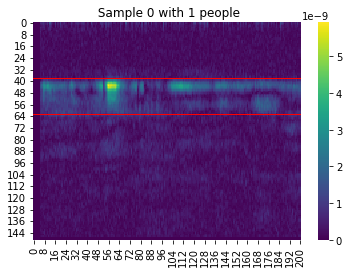

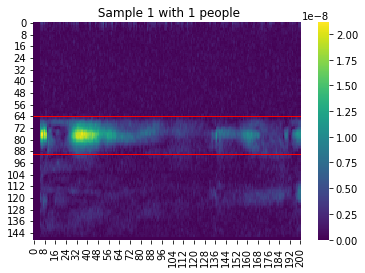

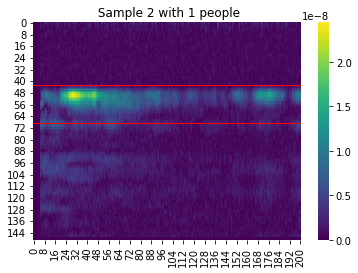

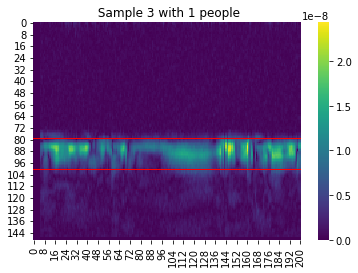

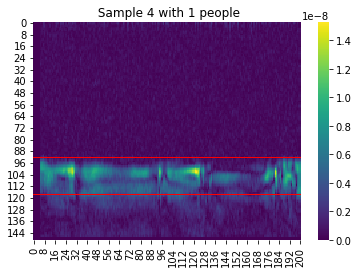

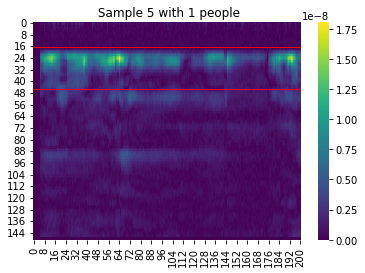

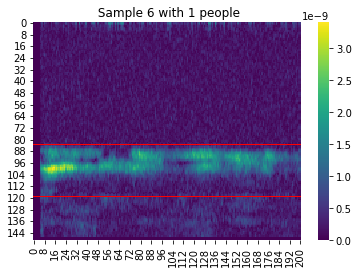

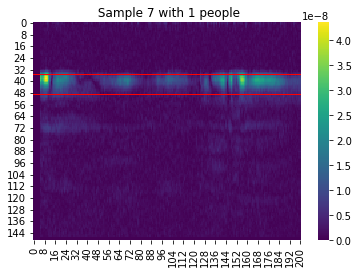

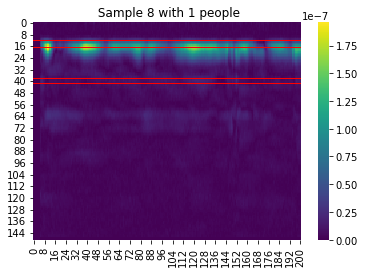

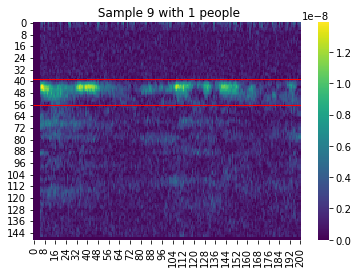

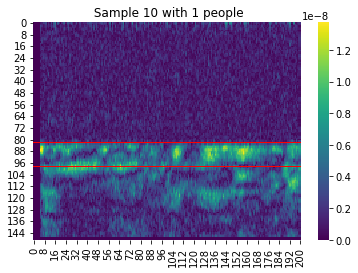

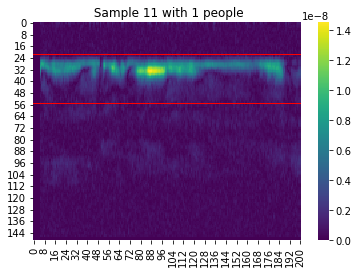

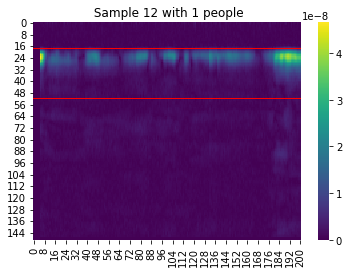

In [20]:
print('Predicted bounding boxes')
for x in range(len(pred_boxes)):
    ax = sns.heatmap(test_df.data.iloc[x], linewidth=0,  cmap="viridis").set_title(f' Sample {x} with {df["presence"][x]} people')
    for i in range(len(pred_boxes[x])):
        ax.axes.add_patch(bbox_to_rect(pred_boxes[x][i]))
    plt.show()

## Check only best predictions

In [25]:
pred_boxes = best_segment_to_bbox(outs)
pred_boxes
check_iou_single(Y_true,pred_boxes)

[0.96, 1.21, 1.02, 1.03, 1.25, 1.2, 1.37, 0.71, 1.55, 0.74, 0.72, 1.47, 1.4]
IOU of image 0: 0.7925806451612906
IOU of image 1: 0.8399999999999997
IOU of image 2: 0.869236583522298
IOU of image 3: 0.7575000000000003
IOU of image 4: 0.8545190034551737
IOU of image 5: 0.6951685783802574
IOU of image 6: 0.7484662576687114
IOU of image 7: 0.6963157894736844
IOU of image 8: 0.6310315430520033
IOU of image 9: 0.8400000000000001
IOU of image 10: 0.5648275862068964
IOU of image 11: 0.7142857142857144
IOU of image 12: 0.5258545135845749
Total IOU of 9.529786214790603, max IOU value is 13, 73.30604780608157%


Original bounding boxes


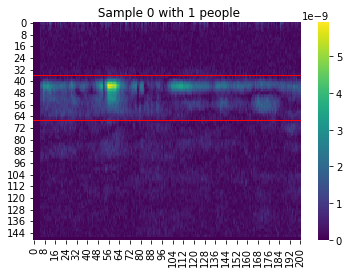

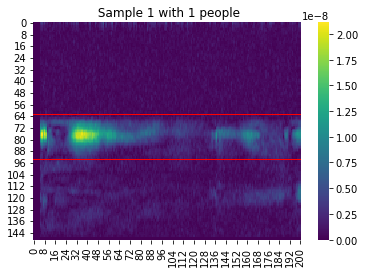

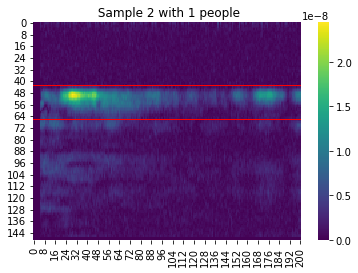

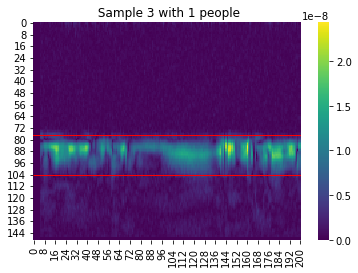

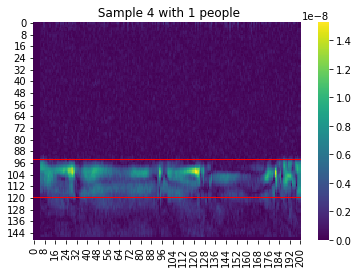

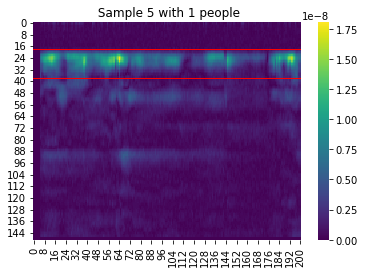

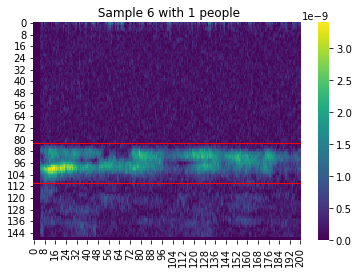

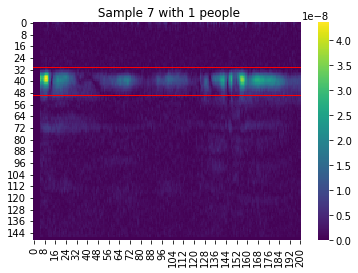

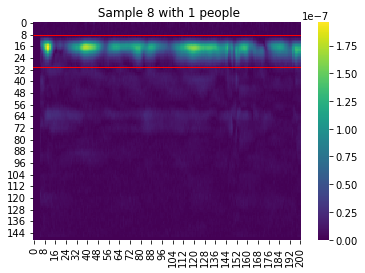

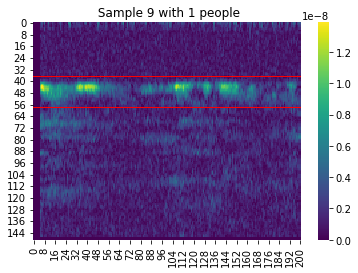

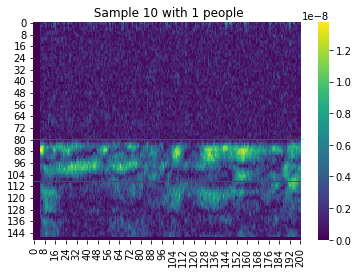

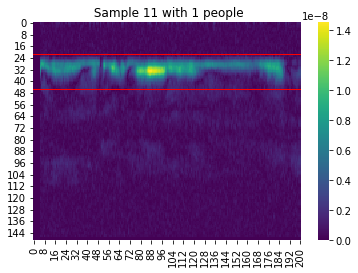

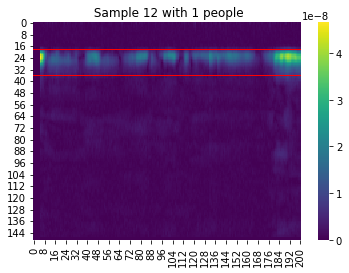

In [27]:
print('Original bounding boxes')
for x in range(len(pred_boxes)):
    ax = sns.heatmap(test_df.data.iloc[x], linewidth=0,  cmap="viridis").set_title(f' Sample {x} with {df["presence"][x]} people')
    ax.axes.add_patch(bbox_to_rect(test_df.bbox.iloc[x]))
    plt.show()

## Comparison with ground truth boxes

Original bounding boxes


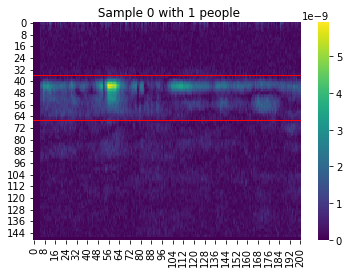

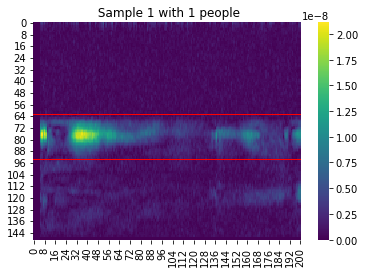

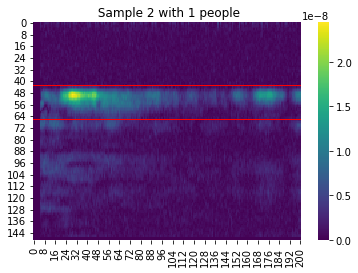

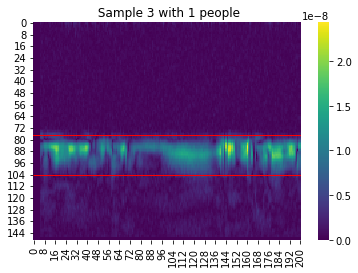

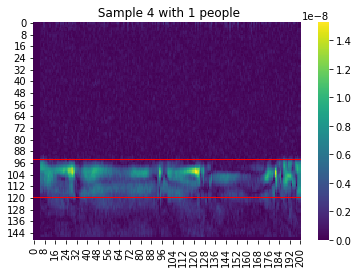

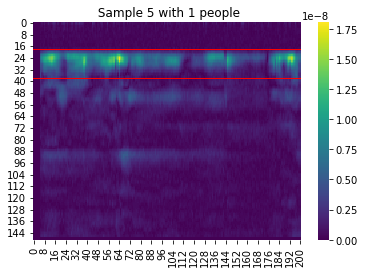

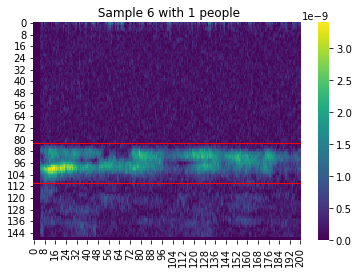

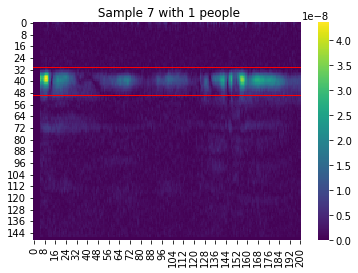

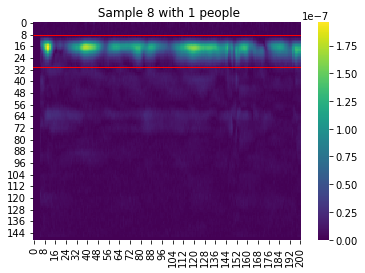

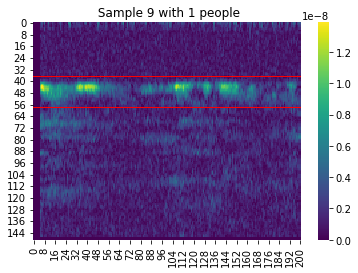

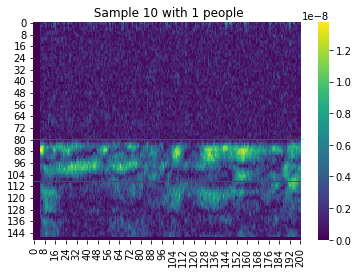

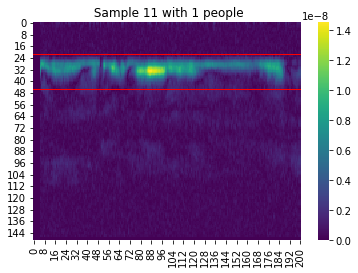

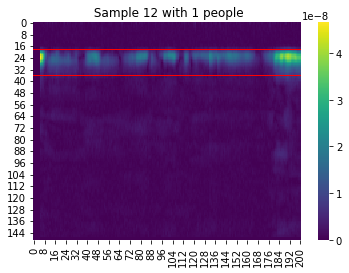

In [21]:
print('Original bounding boxes')
for x in range(len(pred_boxes)):
    ax = sns.heatmap(test_df.data.iloc[x], linewidth=0,  cmap="viridis").set_title(f' Sample {x} with {df["presence"][x]} people')
    ax.axes.add_patch(bbox_to_rect(test_df.bbox.iloc[x]))
    plt.show()

# Checking predictions on empty images

In [72]:
#LOAD 516 DATASET FOR FIRST TRAINING AND VALIDATION
dataframe_name = "df_luis"
pkl_path = f"./pickle/{dataframe_name}.pkl"
df2 = pd.read_pickle(pkl_path)
df2

Id presence  \
0   C:\Users\luisg\radar_acquisitions\recordings\a...        0   
1   C:\Users\luisg\radar_acquisitions\recordings\a...        0   
2   C:\Users\luisg\radar_acquisitions\recordings\a...        0   
3   C:\Users\luisg\radar_acquisitions\recordings\a...        0   
4   C:\Users\luisg\radar_acquisitions\recordings\a...        0   
5   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
6   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
7   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
8   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
9   C:\Users\luisg\radar_acquisitions\recordings\a...        1   
10  C:\Users\luisg\radar_acquisitions\recordings\v...        0   
11  C:\Users\luisg\radar_acquisitions\recordings\v...        0   
12  C:\Users\luisg\radar_acquisitions\recordings\v...        0   
13  C:\Users\luisg\radar_acquisitions\recordings\v...        0   
14  C:\Users\luisg\radar_acquisitions\recordings\v...        0   
15  C:\Users\luisg\radar_acquisitions\recordings\v...        1   
16  C:\Users\luisg\radar_acquisitions\recordings\v...        1   
17  C:\Users\luisg\radar_acquisitions\recordings\v...        1   
18  C:\Users\luisg\radar_acquisitions\recordings\v...        1   
19  C:\Users\luisg\radar_acquisitions\recordings\v...        1   
20  C:\Users\luisg\radar_acquisitions\recordings\e...        0   
21  C:\Users\luisg\radar_acquisitions\recordings\e...        0   
22  C:\Users\luisg\radar_acquisitions\recordings\e...        0   
23  C:\Users\luisg\radar_acquisitions\recordings\e...        0   
24  C:\Users\luisg\radar_acquisitions\recordings\e...        0   
25  C:\Users\luisg\radar_acquisitions\recordings\e...        1   
26  C:\Users\luisg\radar_acquisitions\recordings\e...        1   
27  C:\Users\luisg\radar_acquisitions\recordings\e...        1   
28  C:\Users\luisg\radar_acquisitions\recordings\e...        1   
29  C:\Users\luisg\radar_acquisitions\recordings\e...        1   
30  C:\Users\luisg\radar_acquisitions\recordings\p...        0   
31  C:\Users\luisg\radar_acquisitions\recordings\p...        0   
32  C:\Users\luisg\radar_acquisitions\recordings\p...        0   
33  C:\Users\luisg\radar_acquisitions\recordings\p...        0   
34  C:\Users\luisg\radar_acquisitions\recordings\p...        0   
35  C:\Users\luisg\radar_acquisitions\recordings\p...        1   
36  C:\Users\luisg\radar_acquisitions\recordings\p...        1   
37  C:\Users\luisg\radar_acquisitions\recordings\p...        1   
38  C:\Users\luisg\radar_acquisitions\recordings\p...        1   
39  C:\Users\luisg\radar_acquisitions\recordings\p...        1   
40  C:\Users\luisg\radar_acquisitions\recordings\m...        0   
41  C:\Users\luisg\radar_acquisitions\recordings\m...        0   
42  C:\Users\luisg\radar_acquisitions\recordings\m...        0   
43  C:\Users\luisg\radar_acquisitions\recordings\m...        0   
44  C:\Users\luisg\radar_acquisitions\recordings\m...        0   
45  C:\Users\luisg\radar_acquisitions\recordings\m...        1   
46  C:\Users\luisg\radar_acquisitions\recordings\m...        1   
47  C:\Users\luisg\radar_acquisitions\recordings\m...        1   
48  C:\Users\luisg\radar_acquisitions\recordings\m...        1   
49  C:\Users\luisg\radar_acquisitions\recordings\m...        1   

                                                 data  \
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 3.019567873322238e-...   
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 2.7947315835215067e...   
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 3.3220550761848683e...   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 2.216513852900365e-...   
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.1446887035115177e...   
5   [[0.0, 0.0, 0.0, 0.0, 0.0, 8.034872939559035e-...   
6   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.5555243542351457e...   
7   [[0.0, 0.0, 0.0, 0.0, 0.0, 8.45331887376697e-1...   
8   [[0.0, 0.0, 0.0, 0.0, 0.0, 3.8003771514947853e...   
9   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0471688198795585e...   
10  [[0.0, 0.0, 0.0, 0.0, 0.0, 3.3855472087775085e...   


In [73]:
"""
Perform the same preprocessing steps of the training and test.
"""
test_list = df2["data"][0:5]

images = []
for image in test_list:
    images.append(image)
test_list = images

"""
zscore normalization part of the preprocessing. correcting the dimension of the network.
"""

print(np.mean(test_list))
print(np.std(test_list))
test_list = scipy.stats.zscore(test_list, axis=None)


#max = np.max(train_list)
#min = np.min(train_list)
#train_list = np.array([[[(x - min) / (max - min) for x in y] for y in z] for z in train_list])
test_tensor = tf.convert_to_tensor(test_list)
test_tensor = tf.expand_dims(test_tensor, -1)

print(test_tensor.shape)

test_images = test_tensor

"""
test the best performing network on the test set.
"""

outs = imported_model(test_images)#, test_labels, verbose=2)
outs= tf.reshape(outs,[-1,7,3])
print(outs.shape)
total = []
for prediction in outs:
    image = []
    for row in prediction:
        segment = []
        for value in row:
            segment.append(round(value.numpy(),2))
        image.append(segment)
    total.append(image)
print('Model predictions:')
print(tf.convert_to_tensor(total))

9.315570945381557e-10
6.74551497169534e-10
(5, 149, 201, 1)
(5, 7, 3)
Model predictions:
tf.Tensor(
[[[ 0.75  0.41  0.71]
  [ 0.14  0.11 -0.08]
  [ 0.28 -0.14  0.12]
  [ 0.26  0.26  0.41]
  [ 0.14  0.    0.12]
  [-0.    0.05 -0.15]
  [-0.03 -0.14  0.2 ]]

 [[ 0.61  0.43  0.55]
  [ 0.1   0.06  0.01]
  [ 0.23 -0.04  0.09]
  [ 0.27  0.22  0.39]
  [ 0.08  0.03  0.15]
  [ 0.1   0.06 -0.19]
  [ 0.02 -0.06  0.09]]

 [[ 0.67  0.5   0.49]
  [ 0.2   0.06  0.32]
  [ 0.14 -0.08  0.08]
  [ 0.37  0.11  0.42]
  [ 0.21  0.01  0.29]
  [ 0.14  0.07 -0.22]
  [-0.03  0.1  -0.09]]

 [[ 0.74  0.57  0.43]
  [ 0.23 -0.03  0.34]
  [ 0.14 -0.14  0.06]
  [ 0.44  0.24  0.46]
  [ 0.1   0.11  0.2 ]
  [ 0.13  0.11 -0.17]
  [ 0.02  0.09 -0.18]]

 [[ 0.65  0.65  0.52]
  [ 0.26  0.14  0.4 ]
  [ 0.17 -0.06  0.13]
  [ 0.33  0.09  0.36]
  [ 0.2   0.06  0.28]
  [ 0.12  0.07 -0.16]
  [ 0.06  0.01 -0.06]]], shape=(5, 7, 3), dtype=float32)


In [74]:
outs = model(test_images)#, test_labels, verbose=2)
outs= tf.reshape(outs,[-1,7,3])
print(outs.shape)
total = []
for prediction in outs:
    image = []
    for row in prediction:
        segment = []
        for value in row:
            segment.append(round(value.numpy(),2))
        image.append(segment)
    total.append(image)

best_segment = []
for image in total:
    maxim = 0
    for i in range(0,7):
        if image[i][0] > maxim:
            maxim = image[i][0]
    best_segment.append(maxim)
print(best_segment)

array=[]
for j in range(0, len(total)):
    for i in range(0,7):
        if total[j][i][0] == best_segment[j]:
            center = (total[j][i][1] + i)*21
            height = total[j][i][2]*21
            array.append([round(center,2),round(height,2)])
            
print(array)

(5, 7, 3)
[0.34, 0.37, 0.47, 0.45, 0.51]
[[24.78, 6.3], [23.73, 8.61], [24.99, 9.03], [21.84, 10.08], [23.73, 12.6]]


In [75]:
def bbox_to_rect(bbox):
    """Convert bounding box to matplotlib format"""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(xy=(-1, bbox[0]), width=202,
                             height=bbox[1] - bbox[0], fill=False,
                             edgecolor='red', linewidth=1)

def bbox_borders_to_center(bbox):
    """Convert from (lower border, upper-border) to (center, height)"""
    x1, x2 = bbox[0], bbox[1]
    cx = (x1 + x2) / 2
    h = x2 - x1
    bbox = [cx, h]
    return bbox

def box_center_to_borders(bbox):
    """Convert from (center, height) to (lower border, upper-border)"""
    cx, h = bbox[0], bbox[1]
    x1 = cx - 0.5 * h
    x2 = cx + 0.5 * h
    bbox = [x1, x2]
    return bbox

In [76]:
borders = []

for box in array:
    box = box_center_to_borders(box)
    borders.append(box)
    
print(borders)

[[21.630000000000003, 27.93], [19.425, 28.035], [20.474999999999998, 29.505], [16.8, 26.88], [17.43, 30.03]]


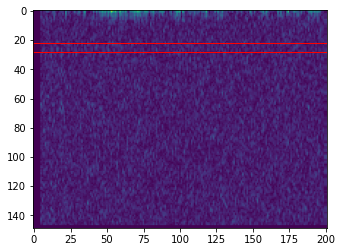

In [77]:
fig = plt.imshow(test_list[0])
fig.axes.add_patch(bbox_to_rect(borders[0]))

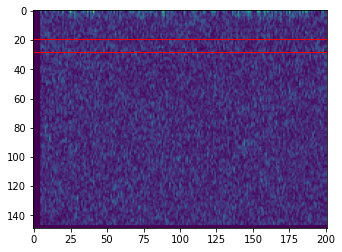

In [78]:
fig = plt.imshow(test_list[1])
fig.axes.add_patch(bbox_to_rect(borders[1]))

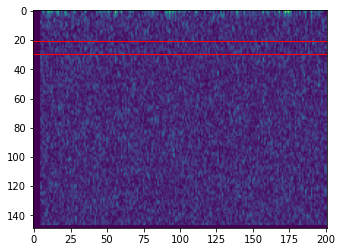

In [79]:
fig = plt.imshow(test_list[2])
fig.axes.add_patch(bbox_to_rect(borders[2]))

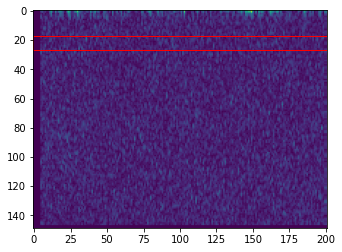

In [80]:
fig = plt.imshow(test_list[3])
fig.axes.add_patch(bbox_to_rect(borders[3]))

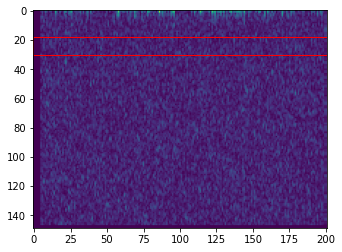

In [81]:
fig = plt.imshow(test_list[4])
fig.axes.add_patch(bbox_to_rect(borders[4]))